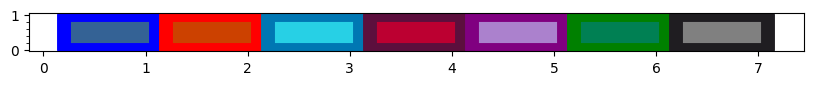

In [50]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as ptchs
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from pandas.core.base import PandasObject
from sklearn.linear_model import Ridge

global_save = True
gpu_system = "das6"
selected_gpu = (
    "A4000"  # Should be same as gpu_system, but forgot to update the benchmark script
)
gpu_vd_input_folder = f"{gpu_system}-gpu/"
gpu_mb_input_folder = f"../microbenchmarks/{gpu_system}/"
gpu_output_folder = f"../../images/{gpu_system}"
selected_blocksize = 256
%run ../notebook_setup.ipynb

In [51]:
gpu_maxsmem = 49152  #
gpu_l2_size = 4194304  # 48 KB
gpu_l2_persistent_size = 3145728  # 48 KB

# Data

# Total validation data

In [52]:
gpu_validation_results = f"{gpu_vd_input_folder}/validation"
gpu_validation_df = pd.read_csv(gpu_validation_results)
gpu_validation_df["nvals"] = gpu_validation_df["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
gpu_validation_df["distribution"] = gpu_validation_df["input"].apply(
    lambda s: s.split("_")[1]
)
gpu_validation_df["env"] = gpu_validation_df["env"].apply(map_env)
convert_to_type(gpu_validation_df, "edges", np.bool_)
convert_to_type(gpu_validation_df, "nvals", np.int64)
convert_to_type(gpu_validation_df, "nbins", np.int64)
del gpu_validation_df["input"]
gpu_validation_df

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.291421,50000000,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,2.370882,100000000,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,7.550797,500000000,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,19.217439,1000000000,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.386995,50000000,normal-0.7-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,4,CUDA,A4000,86,10000000,134217728,False,256,0.0,0.0,0.0,11.842449,1000000000,uniform
5756,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,0.562519,50000000,uniform
5757,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,1.037599,100000000,uniform
5758,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,4.794870,500000000,uniform


In [53]:
groupby_list = ["env", "gpu", "distribution", "nvals", "nbins", "bulksize", "edges"]

In [54]:
gpu_gp_vd = gpu_validation_df.groupby([*groupby_list])
gpu_gp_vd.mean()

iter    cc  \
env  gpu   distribution nvals      nbins    bulksize  edges               
CUDA A4000 constant-0.5 50000000   10       8192      False   2.0  86.0   
                                                      True    2.0  86.0   
                                            16384     False   2.0  86.0   
                                                      True    2.0  86.0   
                                            32768     False   2.0  86.0   
...                                                           ...   ...   
           uniform      1000000000 10000000 2097152   True    2.0  86.0   
                                            16777216  False   2.0  86.0   
                                                      True    2.0  86.0   
                                            134217728 False   2.0  86.0   
                                                      True    2.0  86.0   

                                                             blocksize  \
env  gpu   distribution nvals      nbins    bulksize  edges              
CUDA A4000 constant-0.5 50000000   10       8192      False      256.0   
                                                      True       256.0   
                                            16384     False      256.0   
                                                      True       256.0   
                                            32768     False      256.0   
...                                                                ...   
           uniform      1000000000 10000000 2097152   True       256.0   
                                            16777216  False      256.0   
                                                      True       256.0   
                                            134217728 False      256.0   
                                                      True       256.0   

                                                             tfindbin  tfill  \
env  gpu   distribution nvals      nbins    bulksize  edges                    
CUDA A4000 constant-0.5 50000000   10       8192      False       0.0    0.0   
                                                      True        0.0    0.0   
                                            16384     False       0.0    0.0   
                                                      True        0.0    0.0   
                                            32768     False       0.0    0.0   
...                                                               ...    ...   
           uniform      1000000000 10000000 2097152   True        0.0    0.0   
                                            16777216  False       0.0    0.0   
                                                      True        0.0    0.0   
                                            134217728 False       0.0    0.0   
                                                      True        0.0    0.0   

                                                             tstats     ttotal  
env  gpu   distribution nvals      nbins    bulksize  edges                     
CUDA A4000 constant-0.5 50000000   10       8192      False     0.0   1.052795  
                                                      True      0.0   1.004725  
                                            16384     False     0.0   0.862259  
                                                      True      0.0   0.839961  
                                            32768     False     0.0   0.763279  
...                                                             ...        ...  
           uniform      1000000000 10000000 2097152   True      0.0  11.213498  
                                            16777216  False     0.0   9.874719  
                                                      True      0.0   9.937786  
                                            134217728 False     0.0   9.973750  
                                                      True      0.0   9.939815  

[1152 rows x 7 columns]

In [55]:
vd_unique_env = gpu_validation_df["env"].unique()
vd_unique_bulksize = np.sort(gpu_validation_df["bulksize"].unique())
vd_unique_nbins = np.sort(gpu_validation_df["nbins"].unique())
vd_unique_nvals = np.sort(gpu_validation_df["nvals"].unique().astype(np.float64))
vd_unique_gpus = gpu_validation_df["gpu"].unique()
vd_unique_distributions = gpu_validation_df["distribution"].unique()
vd_unique_edges = [True, False]
vd_unique_env, vd_unique_gpus, vd_unique_nbins, vd_unique_bulksize, vd_unique_edges, vd_unique_nvals, vd_unique_distributions

(array(['CUDA'], dtype=object),
 array(['A4000'], dtype=object),
 array([      10,     1000,   100000, 10000000]),
 array([     8192,     16384,     32768,     65536,    131072,    262144,
          2097152,  16777216, 134217728]),
 [True, False],
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array(['normal-0.4-0.1', 'normal-0.7-0.01', 'constant-0.5', 'uniform'],
       dtype=object))

# NSys data

In [56]:
nsys_gpu_validation_results = f"{gpu_vd_input_folder}/nsys-validation"
api_buf = pd.read_csv(f"{nsys_gpu_validation_results}/api")
api_buf["nvals"] = api_buf["input"].apply(
    lambda s: np.float64(s.split("_")[-1].split(".")[0])
)
api_buf["distribution"] = api_buf["input"].apply(lambda s: s.split("_")[1])
api_buf["env"] = api_buf["env"].apply(map_env)
convert_to_type(api_buf, "edges", np.bool_)
del api_buf["input"]
api_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Num Calls,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,49.0,448620130,61080,7344.8,6602.0,5691,36650198,148276.8,cudaLaunchKernel,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,24.6,225013621,12222,18410.5,20608.5,6121,528369,8181.6,cudaMemcpy,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,20.8,190855173,10,19085517.3,7243.5,4088,190793145,60331910.6,cudaMalloc,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,5.6,50940094,6110,8337.2,8185.0,4348,72095,1551.9,cudaMemset,5.000000e+07,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,0.1,481281,10,48128.1,6276.5,4188,409526,127133.1,cudaFree,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40315,4,CUDA,A4000,86,10000000,134217728,True,256,2.4,30812779,950,32434.5,5069.0,3486,24981135,810304.9,cudaLaunchKernel,1.000000e+09,uniform
40316,4,CUDA,A4000,86,10000000,134217728,True,256,0.7,9209560,11,837232.7,306313.0,2735,2780602,1060177.0,cudaFree,1.000000e+09,uniform
40317,4,CUDA,A4000,86,10000000,134217728,True,256,0.3,3181329,97,32797.2,31659.0,5901,75301,5801.8,cudaMemset,1.000000e+09,uniform
40318,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,124182,1,124182.0,124182.0,124182,124182,0.0,cudaGetDeviceProperties_v2_v12000,1.000000e+09,uniform


In [57]:
gpu_gpapi = api_buf.groupby([*groupby_list, "Name"])
gpu_gpapi.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                      
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode              2.0   
                                                              cudaFree                            2.0   
                                                              cudaGetDeviceProperties_v2_v12000   2.0   
                                                              cudaLaunchKernel                    2.0   
                                                              cudaMalloc                          2.0   
...                                                                                               ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000   2.0   
                                                              cudaLaunchKernel                    2.0   
                                                              cudaMalloc                          2.0   
                                                              cudaMemcpy                          2.0   
                                                              cudaMemset                          2.0   

                                                                                                   cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                      
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode             86.0   
                                                              cudaFree                           86.0   
                                                              cudaGetDeviceProperties_v2_v12000  86.0   
                                                              cudaLaunchKernel                   86.0   
                                                              cudaMalloc                         86.0   
...                                                                                               ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000  86.0   
                                                              cudaLaunchKernel                   86.0   
                                                              cudaMalloc                         86.0   
                                                              cudaMemcpy                         86.0   
                                                              cudaMemset                         86.0   

                                                                                                 blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode                 256.0   
                                                              cudaFree                               256.0   
                                                              cudaGetDeviceProperties_v2_v12000      256.0   
                                                              cudaLaunchKernel                       256.0   
                                                              cudaMalloc                             256.0   
...                                                                                                    ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000      256.0   
                                                              cudaLaunchKernel                       256.0   
                                                              cudaMalloc                             256.0   
                                                              cudaMemcpy                             256.0   
                                             

In [58]:
kernel_buf = pd.read_csv(f"{nsys_gpu_validation_results}/kernel")
kernel_buf["nvals"] = kernel_buf["input"].apply(
    lambda s: np.float64(s.split("_")[-1].split(".")[0])
)
kernel_buf["distribution"] = kernel_buf["input"].apply(lambda s: s.split("_")[1])
kernel_buf["env"] = kernel_buf["env"].apply(map_env)
convert_to_type(kernel_buf, "edges", np.bool_)
del kernel_buf["input"]
kernels_unfiltered = kernel_buf.copy()
kernel_buf["Name"] = kernel_buf["Name"].apply(filter_name)
kernel_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,32.7,145665865,6108,23848.4,23776.0,21825,26880,578.2,FindBin + AddBinContent,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,29.9,133215898,24404,5458.8,5472.0,5407,5568,22.1,UpdateStats,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,8.7,38912425,6101,6378.0,6368.0,6303,6625,29.8,UpdateStats,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,8.2,36472816,6101,5978.2,5984.0,5888,6304,30.1,UpdateStats,5.000000e+07,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,8.1,36149959,6101,5925.3,5920.0,5855,6208,29.2,UpdateStats,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69075,4,CUDA,A4000,86,10000000,134217728,True,256,1.2,39659731,95,417470.9,418945.0,148673,494945,28988.6,UpdateStats,1.000000e+09,uniform
69076,4,CUDA,A4000,86,10000000,134217728,True,256,1.2,39568751,95,416513.2,418337.0,148160,494081,28905.9,UpdateStats,1.000000e+09,uniform
69077,4,CUDA,A4000,86,10000000,134217728,True,256,0.6,20582057,95,216653.2,217536.0,81888,256097,14526.4,UpdateStats,1.000000e+09,uniform
69078,4,CUDA,A4000,86,10000000,134217728,True,256,0.6,20061093,95,211169.4,211936.0,76544,250368,14537.3,UpdateStats,1.000000e+09,uniform


In [59]:
gpu_gp_kernels = kernel_buf.groupby(
    [*groupby_list, "iter", "Name"], as_index=False
).sum()
gpu_gp_kernels = gpu_gp_kernels.groupby([*groupby_list, "Name"])
gpu_gp_kernels_unfiltered = kernels_unfiltered.groupby([*groupby_list, "Name"])
gpu_gp_kernels.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                            
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
                                                              UpdateStats               2.0   
                                                        True  FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
...                                                                                     ...   
           uniform      1.000000e+09 10000000 134217728 False Other                     2.0   
                                                              UpdateStats               2.0   
                                                        True  FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
                                                              UpdateStats               2.0   

                                                                                          cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                             
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
                                                              UpdateStats              860.0   
                                                        True  FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
...                                                                                      ...   
           uniform      1.000000e+09 10000000 134217728 False Other                     86.0   
                                                              UpdateStats              430.0   
                                                        True  FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
                                                              UpdateStats              430.0   

                                                                                       blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                 
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
                                                              UpdateStats                 2560.0   
                                                        True  FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
...                                                                                          ...   
           uniform      1.000000e+09 10000000 134217728 False Other                        256.0   
                                                              UpdateStats                 1280.0   
                                                        True  FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
                                                              UpdateStats                 1280.0   

                                                                                       Time (%)  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent     50.96   
    

In [60]:
memops_buf = pd.read_csv(f"{nsys_gpu_validation_results}/memop")
memops_buf["nvals"] = memops_buf["input"].apply(
    lambda s: np.float64(s.split("_")[-1].split(".")[0])
)
memops_buf["distribution"] = memops_buf["input"].apply(lambda s: s.split("_")[1])
memops_buf["env"] = memops_buf["env"].apply(map_env)
convert_to_type(memops_buf, "edges", np.bool_)
del memops_buf["input"]
memops_buf["Operation"] = memops_buf["Operation"].apply(filter_name)
memops_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Operation,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,86.1,107810209,12220,8822.4,9024.0,896,9504,433.3,HtoD,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,13.9,17462218,6110,2858.0,2848.0,896,3360,66.7,CUDA memset,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,3744,2,1872.0,1872.0,1856,1888,22.6,DtoH,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,84.2,142574435,24440,5833.7,5792.0,512,6752,236.5,HtoD,1.000000e+08,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,15.8,26832872,12220,2195.8,2208.0,512,2752,58.8,CUDA memset,1.000000e+08,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,4,CUDA,A4000,86,10000000,134217728,True,256,1.4,7507431,2,3753715.5,3753715.5,1760,7505671,5306066.4,DtoH,5.000000e+08,uniform
17276,4,CUDA,A4000,86,10000000,134217728,True,256,0.3,1412249,50,28245.0,25599.0,929,197600,24897.3,CUDA memset,5.000000e+08,uniform
17277,4,CUDA,A4000,86,10000000,134217728,True,256,99.0,1020098498,195,5231274.3,5357065.0,416,7229229,950540.9,HtoD,1.000000e+09,uniform
17278,4,CUDA,A4000,86,10000000,134217728,True,256,0.7,7467215,2,3733607.5,3733607.5,1344,7465871,5278217.7,DtoH,1.000000e+09,uniform


In [61]:
gpu_gpmemops = memops_buf.groupby([*groupby_list, "Operation"])
gpu_gpmemops.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset   2.0   
                                                              DtoH          2.0   
                                                              HtoD          2.0   
                                                        True  CUDA memset   2.0   
                                                              DtoH          2.0   
...                                                                         ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH          2.0   
                                                              HtoD          2.0   
                                                        True  CUDA memset   2.0   
                                                              DtoH          2.0   
                                                              HtoD          2.0   

                                                                             cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset  86.0   
                                                              DtoH         86.0   
                                                              HtoD         86.0   
                                                        True  CUDA memset  86.0   
                                                              DtoH         86.0   
...                                                                         ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH         86.0   
                                                              HtoD         86.0   
                                                        True  CUDA memset  86.0   
                                                              DtoH         86.0   
                                                              HtoD         86.0   

                                                                           blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation                
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset      256.0   
                                                              DtoH             256.0   
                                                              HtoD             256.0   
                                                        True  CUDA memset      256.0   
                                                              DtoH             256.0   
...                                                                              ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH             256.0   
                                                              HtoD             256.0   
                                                        True  CUDA memset      256.0   
                                                              DtoH             256.0   
                                                              HtoD             256.0   

                                                                           Time (%)  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation               
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset     13.72   
                                                              DtoH             0.00   
                                                              HtoD            86.28   
                                                        True  CUDA memset     11.40   
                                                              DtoH             0.00   
...                                                                             ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH        

# Microbenchmark data

In [62]:
filename = f"{gpu_mb_input_folder}/gpu_calibration.json"
# filename = "../das6-cpu-microbenchmark.result"

with open(filename, "r") as f:
    jdata = json.load(f)
gpu_bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time": float})

convert_to_type(gpu_bm_df, "real_time", np.float64)
gpu_bm_df["func_name"] = gpu_bm_df["name"].apply(lambda s: s.split("/")[0][3:])
del gpu_bm_df["family_index"], gpu_bm_df["per_family_instance_index"]

convert_to_type(gpu_bm_df, "real_time", np.float64)
convert_to_type(gpu_bm_df, "bulksize", np.int64)
convert_to_type(gpu_bm_df, "nbins", np.int64)
gpu_bm_df

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,...,global,repetition_index,error_occurred,error_message,blocksize,numelements,numthreads,nbytes,pinned,func_name
0,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,1000.0,1,mean,time,3,4.087467e+03,4.085584e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
1,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,1000.0,1,median,time,3,4.078592e+03,4.082013e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
2,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,0.0,1,stddev,time,3,1.626616e+01,1.494498e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
3,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,0.0,1,cv,percentage,3,3.979521e-03,3.657978e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
4,BM_BinarySearchGPU/16/32/min_time:0.001/manual...,BM_BinarySearchGPU/16/32/min_time:0.001/manual...,aggregate,1000.0,1,mean,time,3,4.044800e+03,4.037380e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,BM_MemcpyCPUToGPU/244947350/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/244947350/0/min_time:0.001/m...,aggregate,0.0,1,cv,percentage,3,4.786396e-04,4.620501e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,MemcpyCPUToGPU
2708,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,aggregate,300.0,1,mean,time,3,3.623257e+06,3.618723e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268435452.0,0.0,MemcpyCPUToGPU
2709,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,aggregate,300.0,1,median,time,3,3.623571e+06,3.619073e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268435452.0,0.0,MemcpyCPUToGPU
2710,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,aggregate,0.0,1,stddev,time,3,8.699965e+02,8.905876e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,MemcpyCPUToGPU


# Find Bin

In [63]:
bsbm_df = gpu_bm_df[gpu_bm_df["func_name"] == "BinarySearchGPU"].copy()
bsbm_mean = bsbm_df.loc[bsbm_df["aggregate_name"] == "mean"].reset_index()
bsbm_std = bsbm_df.loc[bsbm_df["aggregate_name"] == "stddev"].reset_index()
bsbm_mean

,index,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,...,global,repetition_index,error_occurred,error_message,blocksize,numelements,numthreads,nbytes,pinned,func_name
0,0,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,1000.0,1,mean,time,3,4087.466558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
1,4,BM_BinarySearchGPU/16/32/min_time:0.001/manual...,BM_BinarySearchGPU/16/32/min_time:0.001/manual...,aggregate,1000.0,1,mean,time,3,4044.799964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
2,8,BM_BinarySearchGPU/32/32/min_time:0.001/manual...,BM_BinarySearchGPU/32/32/min_time:0.001/manual...,aggregate,1000.0,1,mean,time,3,4016.479969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
3,12,BM_BinarySearchGPU/64/32/min_time:0.001/manual...,BM_BinarySearchGPU/64/32/min_time:0.001/manual...,aggregate,1000.0,1,mean,time,3,4021.909396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
4,16,BM_BinarySearchGPU/128/32/min_time:0.001/manua...,BM_BinarySearchGPU/128/32/min_time:0.001/manua...,aggregate,1000.0,1,mean,time,3,4015.413284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,812,BM_BinarySearchGPU/16777216/262144/min_time:0....,BM_BinarySearchGPU/16777216/262144/min_time:0....,aggregate,1000.0,1,mean,time,3,286324.055990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
204,816,BM_BinarySearchGPU/33554432/262144/min_time:0....,BM_BinarySearchGPU/33554432/262144/min_time:0....,aggregate,1000.0,1,mean,time,3,396471.527100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
205,820,BM_BinarySearchGPU/67108864/262144/min_time:0....,BM_BinarySearchGPU/67108864/262144/min_time:0....,aggregate,1000.0,1,mean,time,3,547921.569824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
206,824,BM_BinarySearchGPU/134217728/262144/min_time:0...,BM_BinarySearchGPU/134217728/262144/min_time:0...,aggregate,1000.0,1,mean,time,3,643476.806641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU


## Design

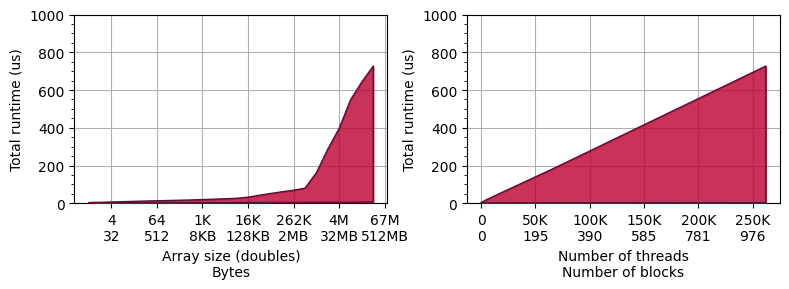

In [64]:
save = global_save; figname = f"{gpu_output_folder}/gpu_binsearch_mb_variance_256blocksize_surface.pdf"  # fmt: skip
selected_size = 33554432
selected_bulksize = 32768
selected_val = 0
unit = "us"
rep = bsbm_mean["repetitions"].values[0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for xi, xname in enumerate(["nbins", "bulksize"]):
    ax = axs[xi]
    arg = ()
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]

    X = avg[xname].unique()
    ymax = []
    ymin = []
    norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    for bki, bks in enumerate(X):
        ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)

    Z = (
        avg["real_time"]
        * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit)
        / rep
    )
    fill_between_edges(ax, X, ymin, ymax, colors[3], ecolors[3], label=f"")

    if xname == "nbins":
        ax.set_xlabel("Array size (doubles)\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
            )
        )
    else:
        ax.set_xlabel("Number of threads\nNumber of blocks")
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
            )
        )
        # ax.plot(avg[xname].unique(), sorted(avg[xname].unique()))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1000)


fig.tight_layout()
# plt.legend(loc="upper left")

# hndls = ax.get_legend_handles_labels()[0]
# lbls = ax.get_legend_handles_labels()[1]
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'},
#            loc='lower left', bbox_to_anchor=(.12, -.15), ncols=4)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()

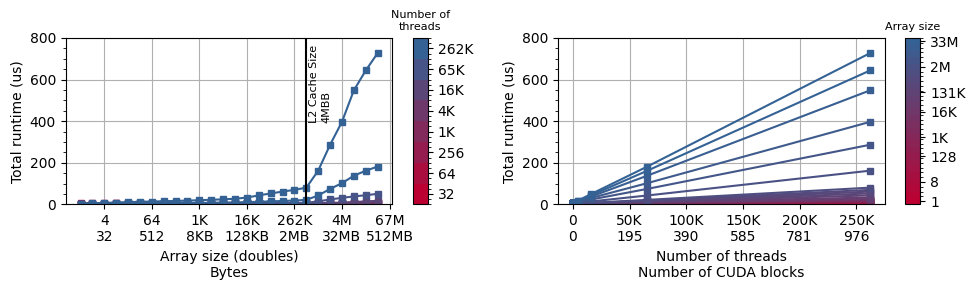

In [65]:
save = global_save; figname = f"{gpu_output_folder}//gpu_binsearch_mb_variance_{int(selected_blocksize)}blocksize_lines.pdf"  # fmt: skip
unit = "us"
rep = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
xnms = ["nbins", "bulksize"]
for xi, xname in enumerate(xnms):
    ax = axs[xi]
    X = bsbm_mean[xnms[(xi + 1) % 2]].unique()

    cmin = 0.15
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        # "", ["#FAEBEF", uvared], N=len(X)
        "",
        [uvared, rootblue],
        N=len(X),
    )
    redcolors = plt.cycler("color", cmap(np.linspace(cmin, 1, len(X)))).by_key()[
        "color"
    ]
    for bki, bks in enumerate(range(0, len(X), 1)):
        arg = bsbm_mean[xnms[(xi + 1) % 2]] == X[bki]
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        ax.plot(
            bsbm_mean[xname].unique(),
            avg["real_time"] * norm,
            **{**bm_style, "color": redcolors[bki], "markerfacecolor": redcolors[bki]},
        )

    if xname == "nbins":
        ax.set_xlabel("Array size (doubles)\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
            )
        )
    else:
        ax.set_xlabel("Number of threads\nNumber of CUDA blocks")
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
            )
        )
        # ax.plot(avg[xname].unique(), sorted(avg[xname].unique()))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 800)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    start_of_clb_cell = np.cumsum(np.repeat(1 / len(X), len(X)))
    middle_of_clb_cell = start_of_clb_cell - (1 / (2 * len(X)))
    div = min(len(X), 8)
    idx = np.linspace(0, len(start_of_clb_cell) - 1, div, dtype=int)

    clb = plt.colorbar(
        sm,
        ticks=middle_of_clb_cell[idx],
        format=ticker.FuncFormatter(
            lambda x, pos, X=X, idx=idx: f"{human_readable(X[idx[pos]])}"
        ),
        ax=ax,
        aspect=11,
    )
    clb.ax.set_title(
        "Number of\nthreads" if xname == "nbins" else "Array size", fontsize=8
    )

# Cache sizes
axs[0].axvline(x=gpu_l2_size / 8, c="k")
axs[0].text(
    gpu_l2_size / 8 * 1.2,
    400,
    f"L2 Cache Size\n{human_readable(gpu_l2_size, bytes=True)}B",
    rotation=90,
    fontsize=8,
)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'},
#            loc='lower left', bbox_to_anchor=(.12, -.15), ncols=4)

# from mpl_toolkits.axes_grid1 import make_axes_locatable

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()

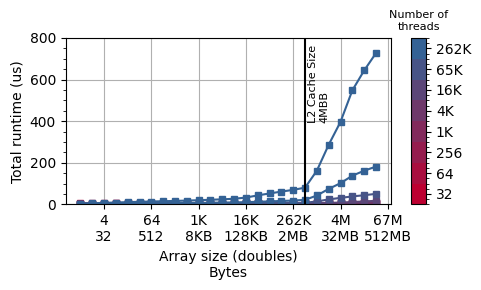

In [66]:
save = global_save; figname = f"{gpu_output_folder}//gpu_binsearch_mb_variance_{int(selected_blocksize)}blocksize_lines.pdf"  # fmt: skip
unit = "us"
rep = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
xnms = ["nbins", "bulksize"]
for xi, xname in enumerate(xnms[:1]):
    ax = axs
    X = bsbm_mean[xnms[(xi + 1) % 2]].unique()

    cmin = 0.15
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        # "", ["#FAEBEF", uvared], N=len(X)
        "",
        [uvared, rootblue],
        N=len(X),
    )
    redcolors = plt.cycler("color", cmap(np.linspace(cmin, 1, len(X)))).by_key()[
        "color"
    ]
    for bki, bks in enumerate(range(0, len(X), 1)):
        arg = bsbm_mean[xnms[(xi + 1) % 2]] == X[bki]
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        ax.plot(
            bsbm_mean[xname].unique(),
            avg["real_time"] * norm,
            **{**bm_style, "color": redcolors[bki], "markerfacecolor": redcolors[bki]},
        )

    if xname == "nbins":
        ax.set_xlabel("Array size (doubles)\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
            )
        )
    else:
        ax.set_xlabel("Number of threads\nNumber of CUDA blocks")
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
            )
        )
        # ax.plot(avg[xname].unique(), sorted(avg[xname].unique()))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 800)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    start_of_clb_cell = np.cumsum(np.repeat(1 / len(X), len(X)))
    middle_of_clb_cell = start_of_clb_cell - (1 / (2 * len(X)))
    div = min(len(X), 8)
    idx = np.linspace(0, len(start_of_clb_cell) - 1, div, dtype=int)

    clb = plt.colorbar(
        sm,
        ticks=middle_of_clb_cell[idx],
        format=ticker.FuncFormatter(
            lambda x, pos, X=X, idx=idx: f"{human_readable(X[idx[pos]])}"
        ),
        ax=ax,
        aspect=11,
    )
    clb.ax.set_title(
        "Number of\nthreads" if xname == "nbins" else "Array size", fontsize=8
    )
    # clb.ax.xaxis.set_ticks(minor=False)
# Cache sizes
ax.axvline(x=gpu_l2_size / 8, c="k")
ax.text(
    gpu_l2_size / 8 * 1.2,
    400,
    f"L2 Cache Size\n{human_readable(gpu_l2_size, bytes=True)}B",
    rotation=90,
    fontsize=8,
)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'},
#            loc='lower left', bbox_to_anchor=(.12, -.15), ncols=4)

# from mpl_toolkits.axes_grid1 import make_axes_locatable

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()

In [67]:
def T_gpu_binsearch(distr, nbins, bulksize):
    subsize = np.array(get_subsize(distr, nbins))
    try:
        T = np.repeat(T_gpu_globmem, len(subsize)).astype(np.float64)
        T[subsize < tau_2] = T_gpu_l2 * (bulksize * p_fb)
        T[subsize < tau_1] = T_gpu_l1 * (bulksize * p_fb)
        return T * (bulksize * p_fb)
    except:
        if subsize < tau_1:
            return T_gpu_l1 * (bulksize * p_fb)
        elif subsize < tau_2:
            return T_gpu_l2 * (bulksize * p_fb)
        else:
            return T_gpu_globmem * (bulksize * p_fb)

## Calibration

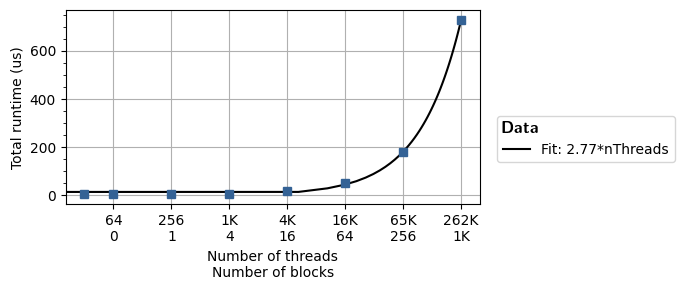

In [68]:
average = False; save = global_save; figname = (f"{gpu_output_folder}/gpu_addbincontent_calib{('_avg' if average else '')}.pdf")  # fmt: skip

###########
def T_bsearch(nthreads, a):
    return a * nthreads


selected_nbins = 33554432
selected_bulksize = 32768 * 8
selected_blocksize = 256
unit = "us"
rep = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

#####
arg = bsbm_mean["nbins"] == selected_nbins
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
x = np.linspace(0, max(avg["bulksize"]))

ax.errorbar(
    avg["bulksize"],
    avg["real_time"] * norm,
    yerr=std["real_time"] * norm,
    marker="s",
    ls="",
    # label=f"v = {int(dest)/4.}"
)

norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], "ns") / rep
T_bsearch_popt, pcov = scipy.optimize.curve_fit(
    T_bsearch,
    avg["bulksize"],
    avg["real_time"] * norm,
    # p0=[6784,24,0],
    # method='trf',
    maxfev=100000,
)
plt.plot(
    x,
    T_bsearch(x, *T_bsearch_popt) * unit_to_unit_factor("ns", unit),
    "k-",
    label="Fit: {}*nThreads".format(*[round(r, 2) for r in T_bsearch_popt]),
)
# ####


plt.xlabel("Number of threads\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
    )
)

if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 500])

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Data}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")

fig.legend(
    hndls,
    lbls,
    title="",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="lower left",
    bbox_to_anchor=(0.99, 0.42),
    ncols=1,
    handler_map={str: LightLegendTitle({"fontsize": 12})},
)
fig.tight_layout()

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [69]:
p_fb = 1 / T_bsearch_popt[0]
p_fb

0.3604613583082697

In [70]:
norm = unit_to_unit_factor("us", "ns")
T_gpu_globmem = 700 * norm
T_gpu_l2 = 100 * norm
T_gpu_l1 = 30 * norm
p_fb = 1 / 262144
tau_1 = 16e3
tau_2 = gpu_l2_size / 8
T_gpu_l1, T_gpu_l2, T_gpu_globmem, "      ", tau_1, tau_2, "      ", p_fb

(30000.0,
 100000.0,
 700000.0,
 '      ',
 16000.0,
 524288.0,
 '      ',
 3.814697265625e-06)

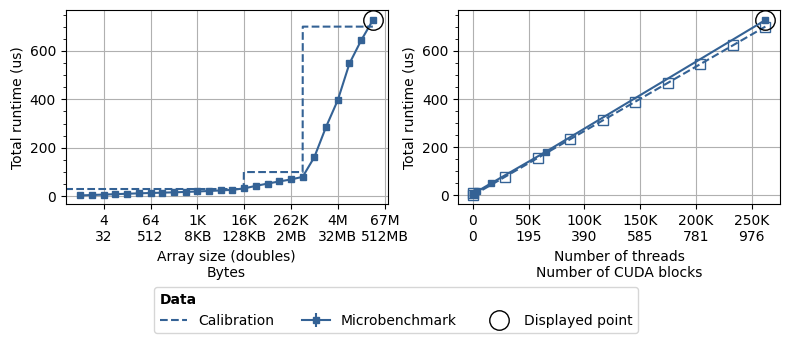

In [71]:
average = False; save = global_save; figname = f"{gpu_output_folder}/gpu_binsearch_calib{('_avg' if average else '')}.pdf"  # fmt: skip

selected_nbins = 33554432
selected_bulksize = 32768 * 8
# selected_bulksize = 1024
selected_blocksize = 256
unit = "us"
rep = bsbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = (
    unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit)
    / rep
    / (selected_bulksize if average else 1)
)
arg = bsbm_mean["bulksize"] == selected_bulksize
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
p = plt.errorbar(
    avg["nbins"],
    avg["real_time"] * norm,
    yerr=std["real_time"] * norm,
    **bm_style,
    label=f"Microbenchmark",
)

# Prediction
x = np.linspace(0, int(max(avg["nbins"])), 1000000)
plt.plot(
    x,
    T_gpu_binsearch("uniform", x, selected_bulksize) * unit_to_unit_factor("ns", unit),
    label="Calibration",
    **{**pred_nocolor_style, "marker": ""},
    color=p[0].get_color(),
)

# selected point
plt.errorbar(
    selected_size,
    avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
    **sl_style,
)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
    )
)

if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# # Cache sizes
# plt.axvline(x=gpu_l2_size/8, c="k")
# plt.text(gpu_l2_size/8*1.2, 350,  f'L2 Cache Size\n{human_readable(gpu_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
arg = bsbm_mean["nbins"] == selected_size
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
norm = (
    unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit)
    / rep
    / (avg["bulksize"] if average else 1)
)
p = plt.errorbar(
    avg["bulksize"], avg["real_time"] * norm, yerr=std["real_time"] * norm, **bm_style
)

# Prediction
x = np.linspace(0, int(max(avg["bulksize"])), 10)
plt.plot(
    x,
    T_gpu_binsearch("uniform", selected_nbins, x) * unit_to_unit_factor("ns", unit),
    len(x),
    color=p[0].get_color(),
    **pred_nocolor_style,
)

# selected point
norm = (
    unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit)
    / rep
    / (selected_bulksize if average else 1)
)
plt.plot(
    selected_bulksize,
    avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
    **sl_style,
    label="Displayed point",
)
plt.xlabel("Number of threads\nNumber of CUDA blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
    )
)
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
# ax.set_ylim([0, 0.02])

fig.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="lower left",
    bbox_to_anchor=(0.19, -0.15),
    ncols=3,
)
fig.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

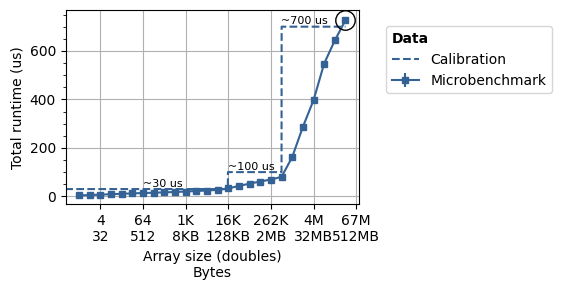

In [72]:
average = False; save = global_save; figname = f"{gpu_output_folder}/gpu_binsearch_calib{('_avg' if average else '')}.pdf"  # fmt: skip

selected_nbins = 33554432
selected_bulksize = 32768 * 8
# selected_bulksize = 1024
selected_blocksize = 256
unit = "us"
rep = bsbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(4, 3))
# ax = plt.subplot(121)
ax = plt.subplot(111)

norm = (
    unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit)
    / rep
    / (selected_bulksize if average else 1)
)
arg = bsbm_mean["bulksize"] == selected_bulksize
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
p = plt.errorbar(
    avg["nbins"],
    avg["real_time"] * norm,
    yerr=std["real_time"] * norm,
    **bm_style,
    label=f"Microbenchmark",
)

# Prediction
x = np.linspace(0, int(max(avg["nbins"])), 1000000)
plt.plot(
    x,
    T_gpu_binsearch("uniform", x, selected_bulksize) * unit_to_unit_factor("ns", unit),
    label="Calibration",
    **{**pred_nocolor_style, "marker": ""},
    color=p[0].get_color(),
)

# selected point
plt.errorbar(
    selected_size,
    avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
    **sl_style,
)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
    )
)

if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# # Cache sizes
# plt.axvline(x=gpu_l2_size/8, c="k")
# plt.text(gpu_l2_size/8*1.2, 350,  f'L2 Cache Size\n{human_readable(gpu_l2_size, bytes=True)}B',rotation=90, fontsize=8)
norm = unit_to_unit_factor("ns", unit)
plt.text(64, (T_gpu_l1 + 1e4) * norm, f"~{round(T_gpu_l1 * norm)} {unit}", fontsize=8)
plt.text(
    16e3, (T_gpu_l2 + 10000) * norm, f"~{round(T_gpu_l2 * norm)} {unit}", fontsize=8
)
plt.text(
    5e5,
    (T_gpu_globmem + 10000) * norm,
    f"~{round(T_gpu_globmem * norm)} {unit}",
    fontsize=8,
)

if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
# ax.set_ylim([0, 0.02])

fig.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="lower left",
    # bbox_to_anchor=(0.19, -0.15),
    # ncols=3,
    bbox_to_anchor=(0.96, 0.65),
    ncols=1,
)
fig.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

## Validation

...

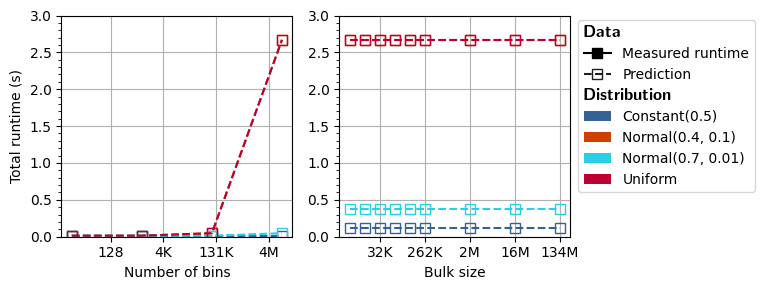

In [73]:
save = global_save; figname = f"{gpu_output_folder}/gpu_findbin_pred.pdf"  # fmt: skip

selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = True
unit = "s"
norm = unit_to_unit_factor("ns", unit)
hmax = 3

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(121)

# Legend Labels
ax.plot(0, 0, label="Measured runtime", c="k", **vd_style)
ax.plot(0, 0, label="Prediction", **pred_style)

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        vd_unique_nbins,
        selected_bulksize,
        selected_edges,
        "FindBin + AddBinContent",
    )
    avg = gpu_gp_kernels.mean().loc[arg]
    std = gpu_gp_kernels.std().loc[arg]

    # p = ax.errorbar(
    #     vd_unique_nbins,
    #     avg["Total Time (ns)"] * norm,
    #     yerr=std["Total Time (ns)"] * norm,
    #     # label=f"{map_distr_name(distr)}".title(),
    #     **vd_style,
    # )

    # prediction
    # T_abc = (
    #     T_gpu_addbincontent(
    #         vd_unique_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, vd_unique_nbins
    #     )
    #     * norm
    #     * (selected_nvals / selected_bulksize)
    # )
    T_fb = (
        T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)
        * norm
        * (selected_nvals / selected_bulksize)
    )
    p = ax.errorbar(vd_unique_nbins, T_fb, **pred_nocolor_style)

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

##########

# ax = plt.subplot(132)
# for di, distr in enumerate(selected_distr):
#     arg = (
#         selected_env,
#         selected_gpu,
#         distr,
#         vd_unique_nvals,
#         selected_nbins,
#         selected_bulksize,
#         selected_edges,
#         "FindBin + AddBinContent",
#     )
#     avg = gpu_gp_kernels.mean().loc[arg]
#     std = gpu_gp_kernels.std().loc[arg]

#     p = ax.errorbar(
#         vd_unique_nvals,
#         avg["Total Time (ns)"] * norm,
#         yerr=std["Total Time (ns)"] * norm,
#         # label=f"{map_distr_name(distr)}".title(),
#         **vd_style,
#     )

#     # prediction
#     T_abc = (
#         T_gpu_addbincontent(
#             selected_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, selected_nbins
#         )
#         * norm
#         * (vd_unique_nvals / selected_bulksize)
#     )
#     T_fb = (
#         T_gpu_binsearch(distr, selected_nbins, selected_bulksize)
#         * norm
#         * (vd_unique_nvals / selected_bulksize)
#     )
#     ax.errorbar(vd_unique_nvals, T_abc + T_fb, c=p[0].get_color(), **pred_nocolor_style)

#     # observ = avg["tstats"].values
#     # print("MAE:", mae(pred, observ))
#     # print("R2:", r2(pred, observ) * 100)

#     plt.xlabel("Number of events")
# plt.xscale("log", base=2)
# ax.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
# )

# plt.ylim([0, hmax])

# #####################
ax = plt.subplot(122)
for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        selected_nbins,
        vd_unique_bulksize,
        selected_edges,
        "FindBin + AddBinContent",
    )
    # avg = gpu_gp_kernels.mean().loc[arg]
    # std = gpu_gp_kernels.std().loc[arg]

    # p = ax.errorbar(
    #     vd_unique_bulksize,
    #     avg["Total Time (ns)"] * norm,
    #     yerr=std["Total Time (ns)"] * norm,
    #     # label=f"{map_distr_name(distr)}".title(),
    #     **vd_style,
    # )

    # prediction
    # T_abc = (
    #     T_gpu_addbincontent(
    #         selected_nbins * 8 > gpu_maxsmem, vd_unique_bulksize, distr, selected_nbins
    #     )
    #     * norm
    #     * (selected_nvals / vd_unique_bulksize)
    # )
    T_fb = (
        T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)
        * norm
        * (selected_nvals / vd_unique_bulksize)
    )
    p = ax.errorbar(vd_unique_bulksize, T_fb, **pred_nocolor_style)

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
# #############

ax = plt.subplot(121)
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
# hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
# lbls.insert(6, "")
fig.tight_layout()
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    # bbox_to_anchor=(0.05, -0.3),
    # ncols=3,
    bbox_to_anchor=(0.96, 0.32),
    ncols=1,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()  # fmt: skip

# Add Bin Content

## Design

In [74]:
abcbm_df = gpu_bm_df[gpu_bm_df["func_name"] == "HistogramGPU"].copy()
abcbm_mean = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"].reset_index()
abcbm_std = abcbm_df.loc[abcbm_df["aggregate_name"] == "stddev"].reset_index()
abcbm_mean

,index,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,...,global,repetition_index,error_occurred,error_message,blocksize,numelements,numthreads,nbytes,pinned,func_name
0,832,BM_HistogramGPU/8/32/1/min_time:0.001/manual_t...,BM_HistogramGPU/8/32/1/min_time:0.001/manual_time,aggregate,1000.0,1,mean,time,3,2853.162686,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
1,836,BM_HistogramGPU/16/32/1/min_time:0.001/manual_...,BM_HistogramGPU/16/32/1/min_time:0.001/manual_...,aggregate,1000.0,1,mean,time,3,2848.426660,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
2,840,BM_HistogramGPU/32/32/1/min_time:0.001/manual_...,BM_HistogramGPU/32/32/1/min_time:0.001/manual_...,aggregate,1000.0,1,mean,time,3,2839.210669,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
3,844,BM_HistogramGPU/64/32/1/min_time:0.001/manual_...,BM_HistogramGPU/64/32/1/min_time:0.001/manual_...,aggregate,1000.0,1,mean,time,3,2840.234598,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
4,848,BM_HistogramGPU/128/32/1/min_time:0.001/manual...,BM_HistogramGPU/128/32/1/min_time:0.001/manual...,aggregate,1000.0,1,mean,time,3,2850.816011,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,2333,BM_HistogramGPU/2048/262144/0/min_time:0.001/m...,BM_HistogramGPU/2048/262144/0/min_time:0.001/m...,aggregate,1000.0,1,mean,time,3,234626.683553,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
308,2337,BM_HistogramGPU/4096/262144/0/min_time:0.001/m...,BM_HistogramGPU/4096/262144/0/min_time:0.001/m...,aggregate,1000.0,1,mean,time,3,235112.792969,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
309,2341,BM_HistogramGPU/8192/262144/0/min_time:0.001/m...,BM_HistogramGPU/8192/262144/0/min_time:0.001/m...,aggregate,1000.0,1,mean,time,3,236520.451864,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
310,2345,BM_HistogramGPU/16384/262144/0/min_time:0.001/...,BM_HistogramGPU/16384/262144/0/min_time:0.001/...,aggregate,1000.0,1,mean,time,3,254948.694865,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU


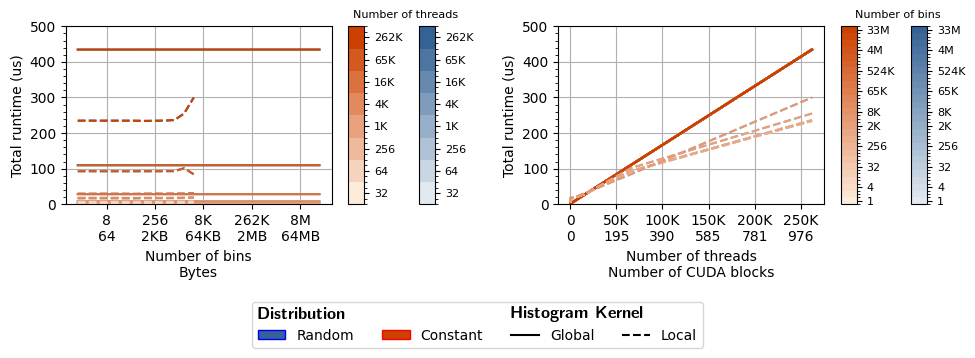

In [75]:
save = global_save; figname = f"{gpu_output_folder}/gpu_addbincontent_mb_variance_256blocksize_lines.pdf";  # fmt: skip

unit = "us"
rep = abcbm_mean["repetitions"].values[0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
xnms = ["nbins", "bulksize"]
X = [sorted(abcbm_mean["bulksize"].unique()), sorted(abcbm_mean["nbins"].unique())]
for xi, xname in enumerate(xnms):
    ax = axs[xi]
    Xs = X[xi]
    for di, rndmdest in enumerate([True, False]):
        cmin = 0
        if rndmdest:
            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                "", ["#E2E9F0", colors[0]], N=len(Xs)
            )
            cmapcolors = plt.cycler(
                "color", cmap(np.linspace(cmin, 1, len(Xs)))
            ).by_key()["color"]
        else:
            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                "", ["#FDEBDB", colors[1]], N=len(Xs)
            )
            cmapcolors = plt.cycler(
                "color", cmap(np.linspace(cmin, 1, len(Xs)))
            ).by_key()["color"]

        for hti, htglbl in enumerate([True, False]):
            # if htglbl: m="s"
            # else: m="o"
            if htglbl:
                ls = "-"
            else:
                ls = "--"

            for bki, bks in enumerate(range(0, len(Xs), 1)):
                arg = (abcbm_mean[xnms[(xi + 1) % 2]] == Xs[bki]) & (
                    abcbm_mean["global"] == htglbl
                )
                avg = abcbm_mean.loc[arg]
                std = abcbm_std.loc[arg]

                norm = (
                    unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
                )
                ax.plot(
                    avg[xname].unique(),
                    avg["real_time"] * norm,
                    ls=ls,
                    # marker=m, ms=5, markerfacecolor=cmapcolors[bki] if htglbl else "none",
                    color=cmapcolors[bki],
                )

        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        start_of_clb_cell = np.cumsum(np.repeat(1 / len(Xs), len(Xs)))
        middle_of_clb_cell = start_of_clb_cell - (1 / (2 * len(Xs)))
        div = min(len(Xs), 10)
        idx = np.linspace(0, len(start_of_clb_cell) - 1, div, dtype=int)
        clb = plt.colorbar(
            sm,
            # ticks=np.linspace(1/len(Xs), 1, len(Xs)) - (1/(2*len(Xs))),
            ticks=middle_of_clb_cell[idx],
            format=ticker.FuncFormatter(
                lambda x, pos, Xs=Xs, idx=idx: f"{human_readable(Xs[idx[pos]])}"
            ),
            ax=ax,
            aspect=11,
        )

        if di == 1:
            clb.ax.set_title(
                (
                    f'{" "*28}Number of threads'
                    if xname == "nbins"
                    else f'{" "*28}Number of bins'
                ),
                fontsize=8,
            )
        clb.ax.tick_params(labelsize=8)

    if xname == "nbins":
        ax.set_xlabel(f"Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
            )
        )
    else:
        ax.set_xlabel("Number of threads\nNumber of CUDA blocks")
        # ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(
                lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
            )
        )
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 500)


######
ax.add_patch(
    ptchs.Rectangle(
        (0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"
    )
)
ax.add_patch(
    ptchs.Rectangle(
        (0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"
    )
)
ax.plot(0, 0, ls="-", color="k", label=f"Global")
ax.plot(0, 0, ls="--", color="k", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(2, "")
hndls.insert(4, r"\noindent\textbf{Histogram Kernel}")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(2, "")
lbls.insert(4, "")
lbls.insert(6, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.25, -0.2),
    ncols=4,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.tight_layout()

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()

## Calibration

[1.64980821e+00 1.92903728e+03]
[8.59765794e-01 1.48295526e+04]


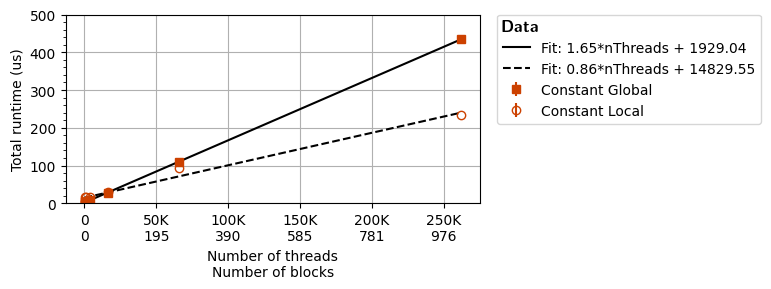

In [76]:
average = False; save = global_save; figname = f"{gpu_output_folder}/gpu_addbincontent_contention_calib{('_avg' if average else '')}.pdf"  # fmt: skip
###########
def T_atomic(nthreads, a, b):
    return a * nthreads + b


selected_nbins = 1
selected_bulksize = 262144
selected_blocksize = 256
selected_val = 0
unit = "us"
rep = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

#####
htglbl = True
rndmdest = False
arg = (abcbm_mean["nbins"] == selected_nbins) & (abcbm_mean["global"] == htglbl)
avg = abcbm_mean.loc[arg]
std = abcbm_std.loc[arg]

x = np.linspace(0, max(avg["bulksize"]))
norm = (
    unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit)
    / rep
    / (avg["bulksize"] if average else 1)
)
ax.errorbar(
    avg["bulksize"],
    avg["real_time"] * norm,
    yerr=std["real_time"] * norm,
    color=colors[1],
    ls="",
    marker="s" if htglbl else "o",
    markerfacecolor=colors[1] if htglbl else "none",
    label=f"Constant {('Global' if htglbl else 'Local')}",
    # **bm_style
)


norm = (
    unit_to_unit_factor(abcbm_mean["time_unit"].values[0], "ns")
    / rep
    / (avg["bulksize"].loc[avg["bulksize"] > 4096] if average else 1)
)
T_globatomic_popt, pcov = scipy.optimize.curve_fit(
    T_atomic,
    avg["bulksize"],
    avg["real_time"] * norm,
    # p0=[6784,24,0],
    # method='trf',
    maxfev=100000,
)
print(T_globatomic_popt)
plt.plot(
    x,
    T_atomic(x, *T_globatomic_popt) * unit_to_unit_factor("ns", unit),
    "k-",
    label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_globatomic_popt]),
)

#####
htglbl = False
rndmdest = False
arg = (abcbm_mean["nbins"] == selected_nbins) & (abcbm_mean["global"] == htglbl)
avg = abcbm_mean.loc[arg]
std = abcbm_std.loc[arg]
norm = (
    unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit)
    / rep
    / (avg["bulksize"] if average else 1)
)
ax.errorbar(
    avg["bulksize"],
    avg["real_time"] * norm,
    yerr=std["real_time"] * norm,
    color=colors[1],
    ls="",
    marker="s" if htglbl else "o",
    markerfacecolor=colors[1] if htglbl else "none",
    label=f"Constant {('Global' if htglbl else 'Local')}",
    # **bm_style
)

norm = (
    unit_to_unit_factor(abcbm_mean["time_unit"].values[0], "ns")
    / rep
    / (avg["bulksize"].loc[avg["bulksize"] > 4096] if average else 1)
)
T_lclatomic_popt, pcov = scipy.optimize.curve_fit(
    T_atomic,
    avg["bulksize"],
    avg["real_time"] * norm,
    # p0=[6784,24,0],
    # method='trf',
    maxfev=100000,
)
print(T_lclatomic_popt)
plt.plot(
    x,
    T_atomic(x, *T_lclatomic_popt) * unit_to_unit_factor("ns", unit),
    "k--",
    label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_lclatomic_popt]),
)

#######

plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
    )
)

if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([0, 500])

# ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
# ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
# ax.plot(0, 0, color="k", marker="s", label=f"Global")
# ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Data}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")

fig.legend(
    hndls,
    lbls,
    title="",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="lower left",
    bbox_to_anchor=(0.99, 0.545),
    ncols=1,
    handler_map={str: LightLegendTitle({"fontsize": 12})},
)
fig.tight_layout()

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [77]:
T_globatomic_popt, T_lclatomic_popt

(array([1.64980821e+00, 1.92903728e+03]),
 array([8.59765794e-01, 1.48295526e+04]))

In [78]:
def T_gpu_addbincontent(global_kernel, bulksize, distr, nbins):
    global_kernel = np.array(global_kernel)
    lcl_kernel = np.invert(global_kernel)
    subsize = np.array(get_subsize(distr, nbins))

    try:
        T = np.zeros(len(global_kernel))
        T[global_kernel] = T_atomic(
            bulksize / subsize[global_kernel], *T_globatomic_popt
        )
        T[lcl_kernel] = T_atomic(bulksize / subsize[lcl_kernel], *T_lclatomic_popt)
    except:
        if global_kernel:
            T = T_atomic(bulksize / subsize, *T_globatomic_popt)

        else:
            T = T_atomic(bulksize / subsize, *T_lclatomic_popt)

    return T


# T_gpu_addbincontent = np.vectorize(T_gpu_addbincontent)

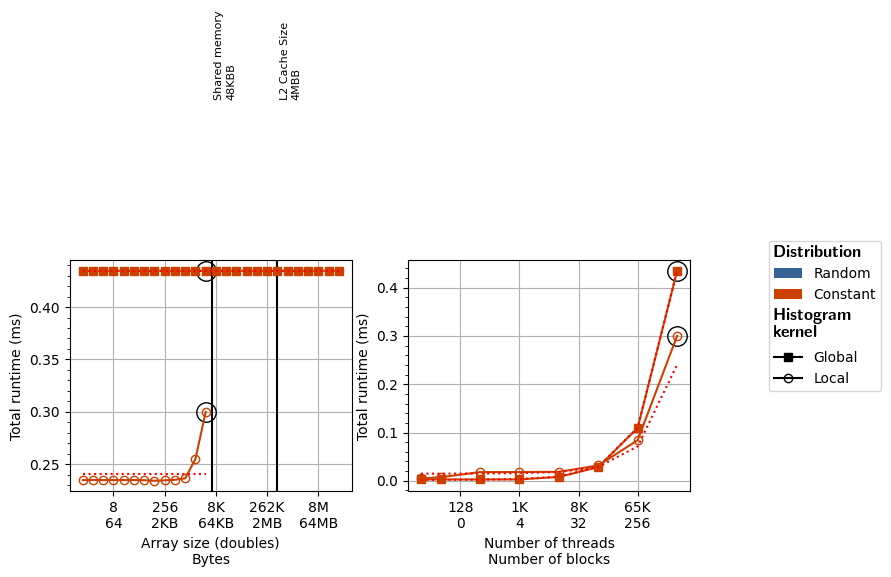

In [79]:
average = False
save = global_save
figname = (
    f"{gpu_output_folder}/gpu_addbincontent_calib{('_avg' if average else '')}.pdf"
)  # fmt: skip

selected_nbins = 4096
selected_bulksize = 262144
selected_blocksize = 256
unit = "ms"
rep = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = (
    unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit)
    / rep
    / (selected_bulksize if average else 1)
)
for hti, htglbl in enumerate([True, False]):
    arg = (abcbm_mean["bulksize"] == selected_bulksize) & (
        abcbm_mean["global"] == htglbl
    )
    avg = abcbm_mean.loc[arg]
    std = abcbm_std.loc[arg]
    c = colors[0] if rndmdest else colors[1]
    ax.errorbar(
        avg["nbins"],
        avg["real_time"] * norm,
        yerr=std["real_time"] * norm,
        color=c,
        marker="s" if htglbl else "o",
        markerfacecolor=c if htglbl else "none",
        # label=f"{'Global' if dest else 'Local'}",
        # **bm_style
    )

    if len(avg.loc[avg["nbins"] == selected_nbins].values) > 0:
        ax.plot(
            selected_nbins,
            avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
            "ok",
            ms=14,
            markerfacecolor="None",
        )

    # Prediction
    c = "b" if rndmdest else "r"
    pred = (
        T_gpu_addbincontent(
            htglbl,
            selected_bulksize,
            "constant",
            avg["nbins"],
        )
        * unit_to_unit_factor("ns", unit)
    )
    ax.errorbar(
        avg["nbins"],
        pred,
        color=c,
        ls=":",
        # marker="s" if htglbl else "o",
        # markerfacecolor=c if htglbl else "none",
    )

plt.axvline(x=gpu_maxsmem / 8, c="k")
plt.text(
    gpu_maxsmem / 8 * 1.2,
    0.6,
    f"Shared memory\n{human_readable(gpu_maxsmem, bytes=True)}B",
    rotation=90,
    fontsize=8,
)
plt.axvline(x=gpu_l2_size / 8, c="k")
plt.text(
    gpu_l2_size / 8 * 1.2,
    0.6,
    f"L2 Cache Size\n{human_readable(gpu_l2_size, bytes=True)}B",
    rotation=90,
    fontsize=8,
)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
    )
)
if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.yscale("log", base=2)
# plt.ylim([3.5, 8])

#############

average = False
ax = plt.subplot(122)
for hti, htglbl in enumerate([True, False]):
    arg = (abcbm_mean["nbins"] == selected_nbins) & (abcbm_mean["global"] == htglbl)
    avg = abcbm_mean.loc[arg]
    std = abcbm_std.loc[arg]

    if len(avg.values) > 0:
        norm = (
            unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit)
            / rep
            / (avg["bulksize"] if average else 1)
        )
        c = colors[0] if rndmdest else colors[1]
        ax.errorbar(
            avg["bulksize"],
            avg["real_time"] * norm,
            yerr=std["real_time"] * norm,
            color=c,
            marker="s" if htglbl else "o",
            markerfacecolor=c if htglbl else "none",
            # label=f"{'Global' if dest else 'Local'}",
            # **bm_style
        )

        # Selected points
        norm = (
            unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit)
            / rep
            / (selected_bulksize if average else 1)
        )
        plt.plot(
            selected_bulksize,
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
            "ok",
            ms=14,
            markerfacecolor="None",
        )

        # Prediction
        c = "b" if rndmdest else "r"
        pred = (
            T_gpu_addbincontent(
                htglbl,
                avg["bulksize"],
                "constant",
                selected_nbins,
            )
            * unit_to_unit_factor("ns", unit)
        )
        ax.errorbar(
            avg["bulksize"],
            pred,
            color=c,
            # ms=13, marker="s" if htglbl else "o",
            # markerfacecolor=c if htglbl else "none",
            # markerfacecolor="k",
            ls=":",
        )

# plt.plot(x, T_atomic * unit_to_unit_factor("ns", unit), 'k-', label="Fitted Curve")

plt.xlabel("Number of threads\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"
    )
)

if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
ax.plot(0, 0, color="k", marker="s", label=f"Global")
ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(
    hndls,
    lbls,
    title="",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="lower left",
    bbox_to_anchor=(0.99, 0.42),
    ncols=1,
    handler_map={str: LightLegendTitle({"fontsize": 12})},
)
# fig.tight_layout()

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

plt.show()

## Validation

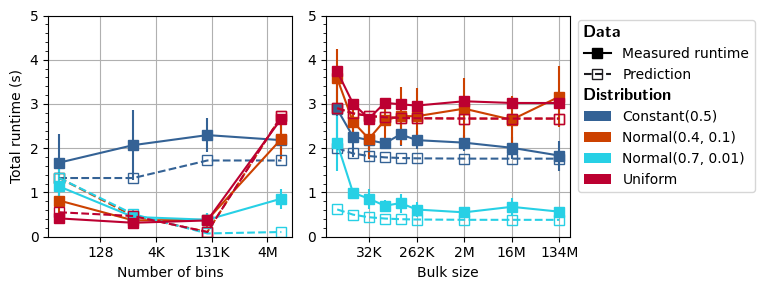

In [80]:
save = global_save; figname = f"{gpu_output_folder}/gpu_addbincontent_validation.pdf"  # fmt: skip

selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = True
unit = "s"
norm = unit_to_unit_factor("ns", unit)
hmax = 5

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(121)

# Legend Labels
ax.plot(0, 0, label="Measured runtime", c="k", **vd_style)
ax.plot(0, 0, label="Prediction", **pred_style)

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        vd_unique_nbins,
        selected_bulksize,
        selected_edges,
        "FindBin + AddBinContent",
    )
    avg = gpu_gp_kernels.mean().loc[arg]
    std = gpu_gp_kernels.std().loc[arg]

    p = ax.errorbar(
        vd_unique_nbins,
        avg["Total Time (ns)"] * norm,
        yerr=std["Total Time (ns)"] * norm,
        # label=f"{map_distr_name(distr)}".title(),
        **vd_style,
    )
    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    # prediction
    T_abc = (
        T_gpu_addbincontent(
            vd_unique_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, vd_unique_nbins
        )
        * norm
        * (selected_nvals / selected_bulksize)
    )
    T_fb = (
        T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)
        * norm
        * (selected_nvals / selected_bulksize)
    )
    ax.errorbar(vd_unique_nbins, T_abc + T_fb, c=p[0].get_color(), **pred_nocolor_style)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

##########

# ax = plt.subplot(132)
# for di, distr in enumerate(selected_distr):
#     arg = (
#         selected_env,
#         selected_gpu,
#         distr,
#         vd_unique_nvals,
#         selected_nbins,
#         selected_bulksize,
#         selected_edges,
#         "FindBin + AddBinContent",
#     )
#     avg = gpu_gp_kernels.mean().loc[arg]
#     std = gpu_gp_kernels.std().loc[arg]

#     p = ax.errorbar(
#         vd_unique_nvals,
#         avg["Total Time (ns)"] * norm,
#         yerr=std["Total Time (ns)"] * norm,
#         # label=f"{map_distr_name(distr)}".title(),
#         **vd_style,
#     )

#     # prediction
#     T_abc = (
#         T_gpu_addbincontent(
#             selected_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, selected_nbins
#         )
#         * norm
#         * (vd_unique_nvals / selected_bulksize)
#     )
#     T_fb = (
#         T_gpu_binsearch(distr, selected_nbins, selected_bulksize)
#         * norm
#         * (vd_unique_nvals / selected_bulksize)
#     )
#     ax.errorbar(vd_unique_nvals, T_abc + T_fb, c=p[0].get_color(), **pred_nocolor_style)

#     # observ = avg["tstats"].values
#     # print("MAE:", mae(pred, observ))
#     # print("R2:", r2(pred, observ) * 100)

#     plt.xlabel("Number of events")
# plt.xscale("log", base=2)
# ax.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
# )

# plt.ylim([0, hmax])

# #####################
ax = plt.subplot(122)
for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        selected_nbins,
        vd_unique_bulksize,
        selected_edges,
        "FindBin + AddBinContent",
    )
    avg = gpu_gp_kernels.mean().loc[arg]
    std = gpu_gp_kernels.std().loc[arg]

    p = ax.errorbar(
        vd_unique_bulksize,
        avg["Total Time (ns)"] * norm,
        yerr=std["Total Time (ns)"] * norm,
        # label=f"{map_distr_name(distr)}".title(),
        **vd_style,
    )

    # prediction
    T_abc = (
        T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, vd_unique_bulksize, distr, selected_nbins
        )
        * norm
        * (selected_nvals / vd_unique_bulksize)
    )
    T_fb = (
        T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)
        * norm
        * (selected_nvals / vd_unique_bulksize)
    )
    ax.errorbar(
        vd_unique_bulksize, T_abc + T_fb, c=p[0].get_color(), **pred_nocolor_style
    )

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
# #############

ax = plt.subplot(121)
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
# hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
# lbls.insert(6, "")
fig.tight_layout()
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    # bbox_to_anchor=(0.05, -0.3),
    # ncols=3,
    bbox_to_anchor=(0.96, 0.32),
    ncols=1,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()  # fmt: skip

# Update Stats

## Design

In [81]:
trbm_df = gpu_bm_df[gpu_bm_df["func_name"] == "TransformReduceGPU"].copy()
trbm_mean = trbm_df.loc[trbm_df["aggregate_name"] == "mean"].reset_index()
trbm_std = trbm_df.loc[trbm_df["aggregate_name"] == "stddev"].reset_index()
trbm_mean

,index,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,...,global,repetition_index,error_occurred,error_message,blocksize,numelements,numthreads,nbytes,pinned,func_name
0,2392,BM_TransformReduceGPU/32/256/min_time:0.001/ma...,BM_TransformReduceGPU/32/256/min_time:0.001/ma...,aggregate,10000.0,1,mean,time,3,29098.955154,...,NaN,NaN,NaN,NaN,256.0,32.0,16.0,NaN,NaN,TransformReduceGPU
1,2396,BM_TransformReduceGPU/64/256/min_time:0.001/ma...,BM_TransformReduceGPU/64/256/min_time:0.001/ma...,aggregate,10000.0,1,mean,time,3,29007.136027,...,NaN,NaN,NaN,NaN,256.0,64.0,32.0,NaN,NaN,TransformReduceGPU
2,2400,BM_TransformReduceGPU/512/256/min_time:0.001/m...,BM_TransformReduceGPU/512/256/min_time:0.001/m...,aggregate,10000.0,1,mean,time,3,28730.367661,...,NaN,NaN,NaN,NaN,256.0,512.0,256.0,NaN,NaN,TransformReduceGPU
3,2404,BM_TransformReduceGPU/4096/256/min_time:0.001/...,BM_TransformReduceGPU/4096/256/min_time:0.001/...,aggregate,10000.0,1,mean,time,3,28634.112040,...,NaN,NaN,NaN,NaN,256.0,4096.0,256.0,NaN,NaN,TransformReduceGPU
4,2408,BM_TransformReduceGPU/32768/256/min_time:0.001...,BM_TransformReduceGPU/32768/256/min_time:0.001...,aggregate,10000.0,1,mean,time,3,32225.621541,...,NaN,NaN,NaN,NaN,256.0,32768.0,256.0,NaN,NaN,TransformReduceGPU
5,2412,BM_TransformReduceGPU/262144/256/min_time:0.00...,BM_TransformReduceGPU/262144/256/min_time:0.00...,aggregate,10000.0,1,mean,time,3,90321.578979,...,NaN,NaN,NaN,NaN,256.0,262144.0,256.0,NaN,NaN,TransformReduceGPU


In [82]:
trbm_mean["numblocks"]

0      1.0
1      1.0
2      1.0
3      8.0
4     64.0
5    512.0
Name: numblocks, dtype: float64

## Calibration

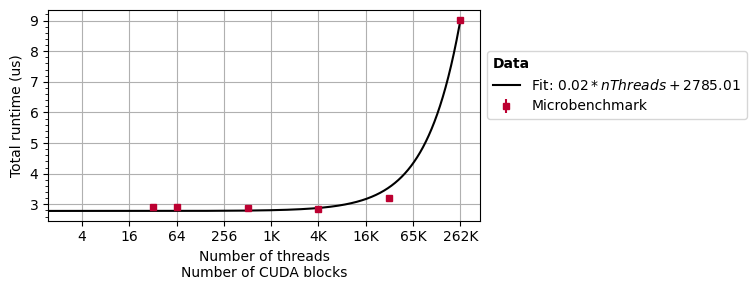

In [83]:
save = global_save; figname = f"{gpu_output_folder}/gpu_updatestats_calib.pdf"  # fmt: skip


def T_gpu_usb(bulksize, a, b):
    return a * bulksize + b


selected_bulksize = 32768 * 8
selected_blocksize = 256
unit = "us"
rep = trbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# microbenchmark data
arg = ()
avg = trbm_mean.loc[arg]
std = trbm_std.loc[arg]
norm = (
    unit_to_unit_factor(trbm_mean["time_unit"].values[0], unit)
    / rep
    / (avg["numelements"] if average else 1)
)
plt.errorbar(
    avg["numelements"],
    avg["real_time"] * norm,
    yerr=std["real_time"] * norm,
    label=f"Microbenchmark",
    c=colors[3],
    ls="",
    **bm_style,
)

## fit line
x = np.linspace(0, pow(2, 18) + 1024, 100000)
norm = (
    unit_to_unit_factor(trbm_mean["time_unit"].values[0], "ns")
    / rep
    / (avg["numelements"] if average else 1)
)
Tusb_popt, pcov = scipy.optimize.curve_fit(
    T_gpu_usb,
    avg["numelements"],
    avg["real_time"] * norm,
    maxfev=100000,
)
# plt.plot(x, T_gpu_usb(x, *Tusb_popt), 'k-', label=r"Fit: ${} * bulkSize^{{{}}} {}$".format(*[round(r, 2) for r in Tusb_popt]))
plt.plot(
    x,
    T_gpu_usb(x, *Tusb_popt) * unit_to_unit_factor("ns", unit),
    "k-",
    label=r"Fit: ${} * nThreads + {}$".format(*[round(r, 2) for r in Tusb_popt]),
)


# plt.plot(x, T_gpu_usb(x, 6000, 24, 0), 'b-', label="Fitted Curve")
# plt.plot(x, T_gpu_usb(x, avg["real_time"].mean()  * norm, 24, 0), 'b-', label="Fitted Curve")

##### Calibration ######
# T_gpu_usb = np.mean(avg["real_time"].loc[avg["bulksize"] > 4096]
#                     / avg["bulksize"].loc[avg["bulksize"] > 4096])  * norm
# plt.plot(x, np.repeat(T_gpu_usb, len(x)), 'k-', label="Calibration")

plt.xlabel("Number of threads\nNumber of CUDA blocks")
plt.xscale("log", base=2)
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        # lambda x, pos, avg=avg: f"{human_readable(int(x))}\n{human_readable(avg['numblocks'].values[pos])}"
        lambda x, pos, avg=avg: f"{human_readable(int(x))}"
    )
)
if average:
    plt.ylabel(f"Average runtime\nper thread ({unit})")
else:
    plt.ylabel(f"Total runtime ({unit})")

plt.tight_layout()
fig.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="center left",
    bbox_to_anchor=(0.97, 0.7),
    ncols=1,
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [84]:
Tusb_popt

array([2.36694237e-02, 2.78500652e+03])

## Validation

64.998046875 128.0


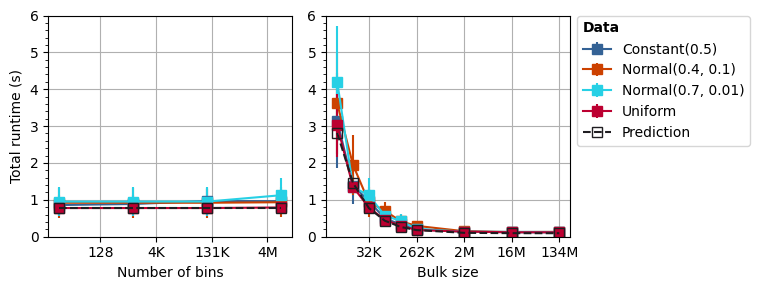

In [85]:
save = global_save; figname = f"{gpu_output_folder}/gpu_updatestats_validation.pdf"  # fmt: skip


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** np.ceil(np.log2(x))


def transformreduce_geometry(bulksize, blocksize):
    threads = (
        next_power_of_2((bulksize + 1) / 2) if bulksize < blocksize * 2 else blocksize
    )
    blocks = (bulksize + (threads * 2 - 1)) / (threads * 2)
    return int(threads), int(blocks)


selected_env = "CUDA"
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = False
unit = "s"
norm = unit_to_unit_factor("ns", unit)
hmax = 6

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(121)

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        vd_unique_nbins,
        selected_bulksize,
        selected_edges,
        "UpdateStats",
    )
    avg = gpu_gp_kernels.mean().loc[arg]
    std = gpu_gp_kernels.std().loc[arg]

    p = ax.errorbar(
        vd_unique_nbins,
        avg["Total Time (ns)"] * norm,
        yerr=std["Total Time (ns)"] * norm,
        label=f"{map_distr_name(distr)}".title(),
        **vd_style,
    )

## Prediction
blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
print(blocks, selected_bulksize / selected_blocksize)
pred = np.repeat(
    (
        T_gpu_usb(selected_bulksize, *Tusb_popt)
        * 4
        * (selected_nvals / selected_bulksize)  # main reduction
        + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals / selected_bulksize)
    )  # final reduction
    * unit_to_unit_factor("ns", "s"),
    len(vd_unique_nbins),
)
ax.errorbar(vd_unique_nbins, pred, label="Prediction", **pred_style)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

#####################
# ax = plt.subplot(132)
# for di, distr in enumerate(selected_distr):
#     arg = (
#         selected_env,
#         selected_gpu,
#         distr,
#         vd_unique_nvals,
#         selected_nbins,
#         selected_bulksize,
#         selected_edges,
#         "UpdateStats",
#     )
#     avg = gpu_gp_kernels.mean().loc[arg]
#     std = gpu_gp_kernels.std().loc[arg]

#     p = ax.errorbar(
#         vd_unique_nvals,
#         avg["Total Time (ns)"] * norm,
#         yerr=std["Total Time (ns)"] * norm,
#         label=f"{map_distr_name(distr)}".title(),
#         **vd_style,
#     )

# ## Prediction
# blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
# pred = (
#     T_gpu_usb(selected_bulksize, *Tusb_popt)
#     * 4
#     * (vd_unique_nvals / selected_bulksize)  # main reduction
#     + T_gpu_usb(blocks, *Tusb_popt) * 4 * (vd_unique_nvals / selected_bulksize)
# ) * unit_to_unit_factor(  # final reduction
#     "ns", "s"
# )
# ax.plot(vd_unique_nvals, pred, label="Prediction", **pred_style)
# # observ = avg["tstats"].values
# # print("MAE:", mae(pred, observ))
# # print("R2:", r2(pred, observ) * 100)

# plt.xlabel("Number of events")
# plt.xscale("log", base=2)
# ax.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
# )
# plt.ylim([0, hmax])

#####################
ax = plt.subplot(122)
for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        selected_nbins,
        vd_unique_bulksize,
        selected_edges,
        "UpdateStats",
    )
    avg = gpu_gp_kernels.mean().loc[arg]
    std = gpu_gp_kernels.std().loc[arg]

    p = ax.errorbar(
        vd_unique_bulksize,
        avg["Total Time (ns)"] * norm,
        yerr=std["Total Time (ns)"] * norm,
        label=f"{map_distr_name(distr)}".title(),
        **vd_style,
    )

## Prediction
blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
pred = (
    T_gpu_usb(vd_unique_bulksize, *Tusb_popt)
    * 4
    * (selected_nvals / vd_unique_bulksize)  # main reduction
    + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals / vd_unique_bulksize)
) * unit_to_unit_factor(  # final reduction
    "ns", "s"
)
ax.errorbar(vd_unique_bulksize, pred, label="Prediction", **pred_style)
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])

##############
fig.tight_layout()
plt.legend(
    title="Data",
    loc="lower left",
    # bbox_to_anchor=(-1.75, -0.6),
    # ncols=3,
    bbox_to_anchor=(1, 0.38),
    ncols=1,
    alignment="left",
    title_fontproperties={"weight": "bold"},
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

# Memory Transfers

## Design

In [86]:
gpu_bm_df

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,...,global,repetition_index,error_occurred,error_message,blocksize,numelements,numthreads,nbytes,pinned,func_name
0,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,1000.0,1,mean,time,3,4.087467e+03,4.085584e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
1,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,1000.0,1,median,time,3,4.078592e+03,4.082013e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
2,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,0.0,1,stddev,time,3,1.626616e+01,1.494498e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
3,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,BM_BinarySearchGPU/8/32/min_time:0.001/manual_...,aggregate,0.0,1,cv,percentage,3,3.979521e-03,3.657978e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
4,BM_BinarySearchGPU/16/32/min_time:0.001/manual...,BM_BinarySearchGPU/16/32/min_time:0.001/manual...,aggregate,1000.0,1,mean,time,3,4.044800e+03,4.037380e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BinarySearchGPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,BM_MemcpyCPUToGPU/244947350/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/244947350/0/min_time:0.001/m...,aggregate,0.0,1,cv,percentage,3,4.786396e-04,4.620501e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,MemcpyCPUToGPU
2708,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,aggregate,300.0,1,mean,time,3,3.623257e+06,3.618723e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268435452.0,0.0,MemcpyCPUToGPU
2709,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,aggregate,300.0,1,median,time,3,3.623571e+06,3.619073e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268435452.0,0.0,MemcpyCPUToGPU
2710,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/268435452/0/min_time:0.001/m...,aggregate,0.0,1,stddev,time,3,8.699965e+02,8.905876e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,MemcpyCPUToGPU


In [87]:
mcpybm_df = gpu_bm_df[gpu_bm_df["func_name"] == "MemcpyCPUToGPU"].copy()
mcpybm_mean = mcpybm_df.loc[mcpybm_df["aggregate_name"] == "mean"].reset_index()
mcpybm_std = mcpybm_df.loc[mcpybm_df["aggregate_name"] == "stddev"].reset_index()
mcpybm_mean

,index,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,...,global,repetition_index,error_occurred,error_message,blocksize,numelements,numthreads,nbytes,pinned,func_name
0,2416,BM_MemcpyCPUToGPU/1/1/min_time:0.001/manual_ti...,BM_MemcpyCPUToGPU/1/1/min_time:0.001/manual_time,aggregate,300.0,1,mean,time,3,1.770837e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,MemcpyCPUToGPU
1,2420,BM_MemcpyCPUToGPU/2/1/min_time:0.001/manual_ti...,BM_MemcpyCPUToGPU/2/1/min_time:0.001/manual_time,aggregate,300.0,1,mean,time,3,1.775893e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,MemcpyCPUToGPU
2,2424,BM_MemcpyCPUToGPU/4/1/min_time:0.001/manual_ti...,BM_MemcpyCPUToGPU/4/1/min_time:0.001/manual_time,aggregate,300.0,1,mean,time,3,1.783125e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,MemcpyCPUToGPU
3,2428,BM_MemcpyCPUToGPU/8/1/min_time:0.001/manual_ti...,BM_MemcpyCPUToGPU/8/1/min_time:0.001/manual_time,aggregate,300.0,1,mean,time,3,1.781120e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,MemcpyCPUToGPU
4,2432,BM_MemcpyCPUToGPU/16/1/min_time:0.001/manual_t...,BM_MemcpyCPUToGPU/16/1/min_time:0.001/manual_time,aggregate,300.0,1,mean,time,3,1.782443e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0,MemcpyCPUToGPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2692,BM_MemcpyCPUToGPU/174483044/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/174483044/0/min_time:0.001/m...,aggregate,300.0,1,mean,time,3,2.362172e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174483044.0,0.0,MemcpyCPUToGPU
70,2696,BM_MemcpyCPUToGPU/197971146/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/197971146/0/min_time:0.001/m...,aggregate,300.0,1,mean,time,3,2.678864e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197971146.0,0.0,MemcpyCPUToGPU
71,2700,BM_MemcpyCPUToGPU/221459248/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/221459248/0/min_time:0.001/m...,aggregate,300.0,1,mean,time,3,2.994838e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221459248.0,0.0,MemcpyCPUToGPU
72,2704,BM_MemcpyCPUToGPU/244947350/0/min_time:0.001/m...,BM_MemcpyCPUToGPU/244947350/0/min_time:0.001/m...,aggregate,300.0,1,mean,time,3,3.309045e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244947350.0,0.0,MemcpyCPUToGPU


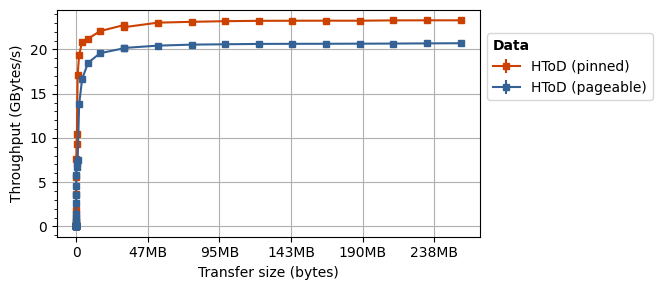

In [88]:
save = global_save; figname = f"{gpu_output_folder}/gpu_memtransfers_mb.pdf"  # fmt: skip
data_unit = "gb"
rep = mcpybm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))

for pi, pinned in enumerate([True, False]):
    # ax = plt.subplot(111)
    # # unit = "s"
    # # norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep

    arg = mcpybm_mean["pinned"] == pinned

    # # plt.plot(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["nbytes"]/mcpybm_mean.loc[arg]["real_time"] * norm, "o-")
    # plt.errorbar(
    #     mcpybm_mean.loc[arg]["nbytes"],
    #     mcpybm_mean.loc[arg]["real_time"] * norm,
    #     yerr=mcpybm_std.loc[arg]["real_time"] * norm,
    #     label=f"{dir} ({('pinned' if pinned else 'pageable')})",
    #     # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
    #     color=colors[pinned],
    #     **bm_style,
    # )
    # plt.xlabel("Bytes")
    # # plt.xlim([0, 10e6])
    # # plt.ylim([0, 5000])
    # plt.xscale("log", base=2)
    # # plt.yscale("symlog")
    # plt.yscale("log")
    # plt.ylabel(f"Average runtime\nper transfer ({unit})")
    # plt.grid()
    # ax.xaxis.set_major_formatter(
    #     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
    # )
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

    ##############
    ax = plt.subplot(111)
    unit = "s"
    norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
    data_norm = unit_to_unit_factor("b", data_unit, bytes=True)
    plt.errorbar(
        mcpybm_mean.loc[arg]["nbytes"],
        # (mcpybm_mean.loc[arg]["real_time"] * norm)/
        #    (mcpybm_mean.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)),
        (mcpybm_mean.loc[arg]["nbytes"] * data_norm)
        / (mcpybm_mean.loc[arg]["real_time"] * norm),
        yerr=(mcpybm_std.loc[arg]["nbytes"] * data_norm)
        / (mcpybm_std.loc[arg]["real_time"] * norm),
        label=f"{dir} ({('pinned' if pinned else 'pageable')})",
        # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
        color=colors[pinned],
        **bm_style,
    )

    # selected point
    # plt.plot(gpu_bw_threshold,
    #          (gpu_bw_threshold  * unit_to_unit_factor("b", data_unit, bytes=True)) /
    #          np.mean(mcpybm_mean.loc[arg & (mcpybm_mean["nbytes"] == gpu_bw_threshold)]["real_time"] * norm),
    #          'ok', ms=14, markerfacecolor="None",)

    plt.xlabel("Transfer size (bytes)")
    # plt.xlim([0, 10e6])
    # plt.ylim([0, 500])
    # plt.xscale("log", base=2)
    # plt.yscale("symlog")
    # plt.yscale("log")
    plt.grid()
    plt.ylabel(f"Throughput ({data_unit.upper()[0]}Bytes/{unit})")
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
    )
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))


plt.tight_layout()
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="center left",
    bbox_to_anchor=(1, 0.75),
    ncols=1,
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

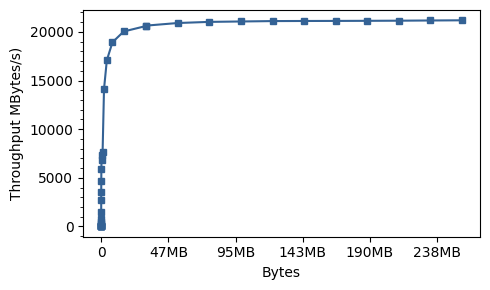

In [89]:
save = global_save; figname = f"{gpu_output_folder}/gpu_memtransfers_mb.pdf"  # fmt: skip
data_unit = "mb"
rep = mcpybm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))

pinned = False

##############
ax = plt.subplot(111)
unit = "s"
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
arg = mcpybm_mean["pinned"] == pinned

plt.errorbar(
    mcpybm_mean.loc[arg]["nbytes"],
    (mcpybm_mean.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True))
    / (mcpybm_mean.loc[arg]["real_time"] * norm),
    yerr=(
        mcpybm_std.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)
    )
    / (mcpybm_std.loc[arg]["real_time"] * norm),
    label=f"{dir} ({('pinned' if pinned else 'pageable')})",
    # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
    color=colors[pinned],
    **bm_style,
)

# selected point
# plt.plot(gpu_bw_threshold,
#          (gpu_bw_threshold  * unit_to_unit_factor("b", data_unit, bytes=True)) /
#          np.mean(mcpybm_mean.loc[arg & (mcpybm_mean["nbytes"] == gpu_bw_threshold)]["real_time"] * norm),
#          'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Bytes")
plt.grid()
plt.ylabel(f"Throughput {data_unit.upper()[0]}Bytes/{unit})")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))


plt.tight_layout()
# plt.legend(
#     title="Data",
#     alignment="left",
#     title_fontproperties={"weight": "bold"},
#     loc="center left",
#     bbox_to_anchor=(1, 0.75),
#     ncols=1,
# )
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

## Calibration

In [138]:
rep = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], "ns") / rep
gpu_alpha_pinned = (
    mcpybm_mean.loc[(mcpybm_mean["pinned"] == True)]["real_time"].values[0] * norm
)
gpu_alpha_paged = (
    mcpybm_mean.loc[(mcpybm_mean["pinned"] == False)]["real_time"].values[0] * norm
)

gpu_alpha_pinned, gpu_alpha_paged = 0, 0

gpu_alpha_pinned, gpu_alpha_paged

(0, 0)

In [139]:
# gpu_bw_threshold = 48 * unit_to_unit_factor("mb", "b", bytes=True)
# norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], "ns") / rep
# arg = mcpybm_mean["nbytes"] >= gpu_bw_threshold
# avg_pinned = mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == True)]
# avg_paged = mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == False)]

# gpu_maxbw_htod_pinned = np.mean(avg_pinned["nbytes"] / (avg_pinned["real_time"] * norm))
# gpu_maxibw_htod_pinned = np.mean(
#     (avg_pinned["real_time"] * norm) / avg_pinned["nbytes"]
# )

# gpu_maxbw_htod_paged = np.mean(avg_paged["nbytes"] / (avg_paged["real_time"] * norm))
# gpu_maxibw_htod_paged = np.mean((avg_paged["real_time"] * norm) / avg_paged["nbytes"])

# print("threshold", gpu_bw_threshold)
# print("max bw/ibw pinned", gpu_maxbw_htod_pinned, gpu_maxibw_htod_pinned)
# print("max bw/ibw paged", gpu_maxbw_htod_paged, gpu_maxibw_htod_paged)

In [140]:
gpu_bw_threshold = 48 * unit_to_unit_factor("mb", "b", bytes=True)
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], "ns") / rep
arg = mcpybm_mean["nbytes"] >= gpu_bw_threshold
avg_pinned = mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == True)]
avg_paged = mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == False)]

gpu_maxbw_htod_pinned = np.mean(
    avg_pinned["nbytes"] / (avg_pinned["real_time"] * norm - gpu_alpha_pinned)
)
gpu_maxibw_htod_pinned = np.mean(
    (avg_pinned["real_time"] * norm - gpu_alpha_pinned) / avg_pinned["nbytes"]
)

gpu_maxbw_htod_paged = np.mean(
    avg_paged["nbytes"] / (avg_paged["real_time"] * norm - gpu_alpha_paged)
)
gpu_maxibw_htod_paged = np.mean(
    (avg_paged["real_time"] * norm - gpu_alpha_paged) / avg_paged["nbytes"]
)

print("threshold", gpu_bw_threshold)
print("max lambda pinned", gpu_maxbw_htod_pinned, gpu_maxibw_htod_pinned)
print("max lambda paged", gpu_maxbw_htod_paged, gpu_maxibw_htod_paged)

threshold 50331648.0
max lambda pinned 24.927350367109455 0.0401170602183392
max lambda paged 22.133261617010284 0.045181480128875004


In [141]:
# def ibw_small(bytes, a, b, c):
#     return a * (np.log(bytes) / np.log(b)) + c

# def ibw_small(bytes, a, b):
#     return a*bytes + b

# def ibw_small(bytes, a, b, c):
#     return a*(np.log(bytes) / np.log(b)) + c

# def ibw_small(bytes, a,b,c):
#     return a*pow(bytes, b) + c

def ibw_small(x, *coeffs):
    y = np.polyval(coeffs, x)
    return y


# def ibw_small(bytes, a, b, c, d):
#     # def ibw_small(bytes, a, b, c, d, e, f):
#     return (
#         a * pow(bytes, 0)
#         + b * pow(bytes, 1)
#         + c * pow(bytes, 2)
#         + d * pow(bytes, 3)
#         + e * pow(bytes, 4)
#         + f * pow(bytes, 5)
#         #             + g *pow(bytes, 6)
#         #             + h *pow(bytes, 7)
#         #             + i *pow(bytes, 8)
#     ).clip(0)


def get_poly_label(popt, r=3):
    s = []
    np = len(popt)
    res = ""
    for i in range(np - 1, -1, -1):
        p = round(popt[i], r)
        if p != 0:
            if i != np-1 and p > 0:
                res+= " + "
                
            if i == 0:
                res += f"{p}"
            elif i == 1:
                res += f"{p}x"
            else:
                res += f"{p}x^{i}"
                
    return res

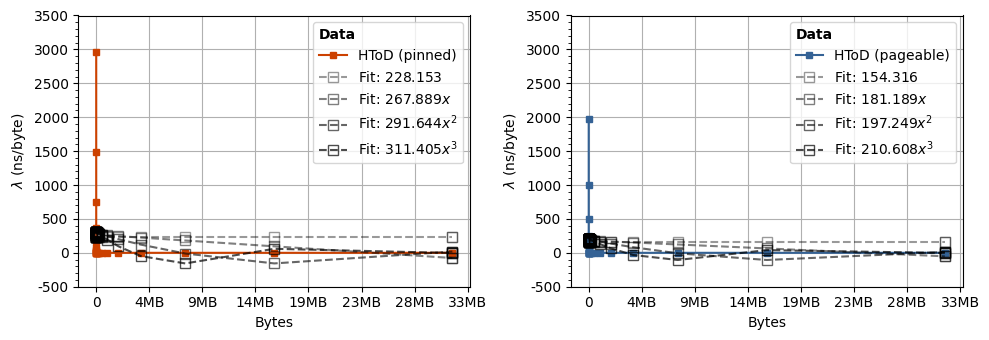

In [183]:
save = True; figname = f"{gpu_output_folder}/gpu_memtransfers_calib_lambda.pdf"  # fmt: skip

unit = "ns"
data_unit = "b"
rep = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
dir = "HToD"
deg = 5

fig = plt.figure(figsize=(10, 3.5))

ax = plt.subplot(121)
pinned = True
arg = mcpybm_mean["pinned"] == pinned

ylambda = mcpybm_mean.loc[arg]["real_time"] * norm - gpu_alpha_pinned
ylambda_std = mcpybm_std.loc[arg]["real_time"] * norm
xbytes = mcpybm_mean.loc[arg]["nbytes"]
# print(mcpybm_mean.loc[arg]["real_time"] * norm  - gpu_alpha_pinned)
mask = (xbytes > 1) & (xbytes < gpu_bw_threshold)
p = plt.errorbar(
    xbytes[mask],
    ylambda[mask] / xbytes[mask],
    # yerr=ylambda_std[mask] / xbytes[mask],
    label=f"{dir} ({('pinned' if pinned else 'pageable')})",
    color=colors[1],
    # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
    **bm_style,
)

ibw_smallpinned_popt = []
for i, n in enumerate(range(deg-4, deg)):
    # The initial guess of the parameters to be found by curve_fit.
    # Warning: in general, an array of ones might not be a good enough
    # guess for `curve_fit`, but in this example, it works.
    p0 = np.ones(n) * 1
    popt, pcov = scipy.optimize.curve_fit(
        ibw_small,
        xbytes[mask],
        ylambda[mask] / xbytes[mask],
        p0=p0,
        method="trf",
        maxfev=1e6,
    )
    # XXX Should check pcov here, but in this example, curve_fit converges.

    ibw_smallpinned_popt.append(popt)

    plt.errorbar(
        xbytes[mask],
        ibw_small(xbytes[mask], *ibw_smallpinned_popt[i]),
        # c=p[0].get_color(),
        c="k",
        alpha=0.1 * i + 0.4,
        **pred_nocolor_style,
        label=f"Fit: ${get_poly_label(ibw_smallpinned_popt[i])}$",
    )

# ibw_smallpinned_popt, pcov = scipy.optimize.curve_fit(
#     ibw_small,
#     xbytes[mask],
#     ylambda[mask] * unit_to_unit_factor(unit, "ns"),
#     # p0=[6784,24,0],
#     # method='trf',
#     # bounds=(0,np.inf),
#     # p0=[6.315361645565791e-11, 0],
#     # maxfev=100000
# )
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="upper right",
    # bbox_to_anchor=(1, 0.75),
    # ncols=1,
)

plt.xlabel("Bytes")
plt.ylim([-500, 3500])
plt.ylabel(f"$\lambda$ ({unit}/{data_unit}yte)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

##############
ax = plt.subplot(122)

pinned = False
arg = mcpybm_mean["pinned"] == pinned
xbytes = mcpybm_mean.loc[arg]["nbytes"]
mask = (xbytes > 1) & (xbytes < gpu_bw_threshold)
ylambda = mcpybm_mean.loc[arg]["real_time"] * norm - gpu_alpha_paged
ylambda_std = mcpybm_std.loc[arg]["real_time"] * norm

p = plt.errorbar(
    xbytes[mask],
    ylambda[mask] / xbytes[mask],
    # yerr=ylambda_std[mask] / xbytes[mask],
    label=f"{dir} ({('pinned' if pinned else 'pageable')})",
    color=colors[0],
    # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
    **bm_style,
)

ibw_smallpaged_popt = []
for i, n in enumerate(range(deg-4, deg)):
    # The initial guess of the parameters to be found by curve_fit.
    # Warning: in general, an array of ones might not be a good enough
    # guess for `curve_fit`, but in this example, it works.
    p0 = np.ones(n) * 1
    popt, pcov = scipy.optimize.curve_fit(
        ibw_small,
        xbytes[mask],
        ylambda[mask] / xbytes[mask],
        p0=p0,
        method="trf",
        maxfev=1e6,
    )
    ibw_smallpaged_popt.append(popt)

    plt.errorbar(
        xbytes[mask],
        ibw_small(xbytes[mask], *ibw_smallpaged_popt[i]),
        # c=p[0].get_color(),
        c="k",
        alpha=0.1 * i + 0.4,
        **pred_nocolor_style,
        label=f"Fit: ${get_poly_label(ibw_smallpaged_popt[i])}$",
    )

# ibw_smallpaged_popt, pcov = scipy.optimize.curve_fit(
#     ibw_small,
#     xbytes[mask],
#     ylambda[mask] * unit_to_unit_factor(unit, "ns"),
#     # p0=[6e-2, 6e3, 0, 0, 0, 0],
#     # method='trf',
#     # bounds=(0,np.inf),
#     maxfev=100000,
# )
# plt.errorbar(
#     xbytes[mask],
#     ibw_small(xbytes[mask], *ibw_smallpaged_popt),
#     c=p[0].get_color(),
#     **pred_nocolor_style,
#     label=f"Fit ${get_poly_label(ibw_smallpaged_popt)}$",
# )

# plt.plot(xbytes[mask], 6e-2*xbytes[mask] + 6e3, "--")
plt.xlabel("Bytes")
# plt.xlim([0, 10e6])
plt.ylim([-500, 3500])
# plt.xscale("log", base=2)
# plt.yscale("symlog")
# plt.yscale("log")
# plt.ylabel(f"$\lambda$ ({unit}/byte)")
plt.ylabel(f"$\lambda$ ({unit}/{data_unit}yte)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

plt.tight_layout()
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="upper right",
    # bbox_to_anchor=(1, 0.75),
    # ncols=1,
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [172]:
ibw_smallpaged_popt

[array([ 7.48028458e-13, -3.06061378e-05,  1.97230622e+02]),
 array([-1.21359828e-19,  6.33768439e-12, -8.23431037e-05,  2.10624131e+02]),
 array([ 3.46147105e-26, -2.04969998e-18,  3.53822234e-11, -1.93849183e-04,
         2.23930200e+02]),
 array([-1.94904723e-32,  1.22872190e-24, -2.42053590e-17,  1.78372123e-10,
        -4.52473189e-04,  2.48933865e+02])]

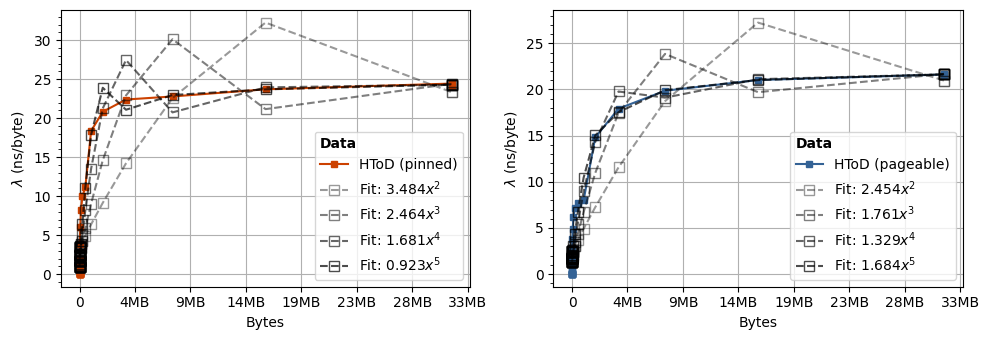

In [162]:
# save = False; figname = f"{gpu_output_folder}/gpu_memtransfers_calib_small_throughput.pdf"  # fmt: skip

# unit = "ns"
# data_unit = "b"
# rep = mcpybm_mean["repetitions"].values[0]
# norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
# dir = "HToD"
# deg = 7

# fig = plt.figure(figsize=(10, 3.5))

# ax = plt.subplot(121)
# pinned = True
# arg = mcpybm_mean["pinned"] == pinned

# ylambda = mcpybm_mean.loc[arg]["real_time"] * norm - gpu_alpha_pinned
# ylambda_std = mcpybm_std.loc[arg]["real_time"] * norm
# xbytes = mcpybm_mean.loc[arg]["nbytes"]
# # print(mcpybm_mean.loc[arg]["real_time"] * norm  - gpu_alpha_pinned)
# mask = (xbytes > 1) & (xbytes < gpu_bw_threshold)
# p = plt.errorbar(
#     xbytes[mask],
#     xbytes[mask]/ylambda[mask],
#     # yerr=ylambda_std[mask] / xbytes[mask],
#     label=f"{dir} ({('pinned' if pinned else 'pageable')})",
#     color=colors[1],
#     # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
#     **bm_style,
# )

# ibw_smallpinned_popt = []
# for i, n in enumerate(range(deg-4, deg)):
#     # The initial guess of the parameters to be found by curve_fit.
#     # Warning: in general, an array of ones might not be a good enough
#     # guess for `curve_fit`, but in this example, it works.
#     p0 = np.ones(n) * 1
#     popt, pcov = scipy.optimize.curve_fit(
#         ibw_small,
#         xbytes[mask],
#         xbytes[mask]/ylambda[mask],
#         p0=p0,
#         method="trf",
#         # bounds=(0,np.inf),
#         maxfev=1e6,
#     )
#     # XXX Should check pcov here, but in this example, curve_fit converges.

#     ibw_smallpinned_popt.append(popt)

#     plt.errorbar(
#         xbytes[mask],
#         ibw_small(xbytes[mask], *ibw_smallpinned_popt[i]),
#         # c=p[0].get_color(),
#         c="k",
#         alpha=0.1 * i + 0.4,
#         **pred_nocolor_style,
#         label=f"Fit: ${get_poly_label(ibw_smallpinned_popt[i])}$",
#     )

# # ibw_smallpinned_popt, pcov = scipy.optimize.curve_fit(
# #     ibw_small,
# #     xbytes[mask],
# #     ylambda[mask] * unit_to_unit_factor(unit, "ns"),
# #     # p0=[6784,24,0],
# #     # method='trf',
# #     # bounds=(0,np.inf),
# #     # p0=[6.315361645565791e-11, 0],
# #     # maxfev=100000
# # )
# plt.legend(
#     title="Data",
#     alignment="left",
#     title_fontproperties={"weight": "bold"},
#     loc="lower right",
#     # bbox_to_anchor=(1, 0.75),
#     # ncols=1,
# )

# plt.xlabel("Bytes")
# # plt.xscale("log", base=2)
# plt.ylabel(f"$\lambda$ ({unit}/{data_unit}yte)")
# ax.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
# )
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

# ##############
# ax = plt.subplot(122)

# pinned = False
# arg = mcpybm_mean["pinned"] == pinned
# xbytes = mcpybm_mean.loc[arg]["nbytes"]
# mask = (xbytes > 1) & (xbytes < gpu_bw_threshold)
# ylambda = mcpybm_mean.loc[arg]["real_time"] * norm - gpu_alpha_paged
# ylambda_std = mcpybm_std.loc[arg]["real_time"] * norm

# p = plt.errorbar(
#     xbytes[mask],
#     xbytes[mask]/ylambda[mask],
#     # yerr=ylambda_std[mask] / xbytes[mask],
#     label=f"{dir} ({('pinned' if pinned else 'pageable')})",
#     color=colors[0],
#     # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
#     **bm_style,
# )

# ibw_smallpaged_popt = []
# for i, n in enumerate(range(deg-4, deg)):
#     # The initial guess of the parameters to be found by curve_fit.
#     # Warning: in general, an array of ones might not be a good enough
#     # guess for `curve_fit`, but in this example, it works.
#     p0 = np.ones(n) * 0.1
#     popt, pcov = scipy.optimize.curve_fit(
#         ibw_small,
#         xbytes[mask],
#         xbytes[mask]/ylambda[mask],
#         p0=p0,
#         method="trf",
#         maxfev=1e6,
#         # bounds=(0,np.inf),
#     )
#     ibw_smallpaged_popt.append(popt)

#     plt.errorbar(
#         xbytes[mask],
#         ibw_small(xbytes[mask], *ibw_smallpaged_popt[i]),
#         # c=p[0].get_color(),
#         c="k",
#         alpha=0.1 * i + 0.4,
#         **pred_nocolor_style,
#         label=f"Fit: ${get_poly_label(ibw_smallpaged_popt[i])}$",
#     )

# # ibw_smallpaged_popt, pcov = scipy.optimize.curve_fit(
# #     ibw_small,
# #     xbytes[mask],
# #     ylambda[mask] * unit_to_unit_factor(unit, "ns"),
# #     # p0=[6e-2, 6e3, 0, 0, 0, 0],
# #     # method='trf',
# #     # bounds=(0,np.inf),
# #     maxfev=100000,
# # )
# # plt.errorbar(
# #     xbytes[mask],
# #     ibw_small(xbytes[mask], *ibw_smallpaged_popt),
# #     c=p[0].get_color(),
# #     **pred_nocolor_style,
# #     label=f"Fit ${get_poly_label(ibw_smallpaged_popt)}$",
# # )

# # plt.plot(xbytes[mask], 6e-2*xbytes[mask] + 6e3, "--")
# plt.xlabel("Bytes")
# # plt.xlim([0, 10e6])
# # plt.ylim([0, 500])
# # plt.xscale("log", base=2)
# # plt.yscale("symlog")
# # plt.yscale("log")
# # plt.ylabel(f"$\lambda$ ({unit}/byte)")
# plt.ylabel(f"$\lambda$ ({unit}/{data_unit}yte)")
# ax.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
# )
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

# plt.tight_layout()
# plt.legend(
#     title="Data",
#     alignment="left",
#     title_fontproperties={"weight": "bold"},
#     loc="lower right",
#     # bbox_to_anchor=(1, 0.75),
#     # ncols=1,
# )
# if save:
#     plt.savefig(figname, format="pdf", bbox_inches="tight")
# plt.show()

In [177]:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6650995
# def T_memcpy_das6(bytes, pinned):
#     alpha = gpu_alpha_pinned if pinned else gpu_alpha_paged
#     maxibw = gpu_maxibw_htod_pinned if pinned else gpu_maxibw_htod_paged
#     popt = ibw_smallpinned_popt[2] if pinned else ibw_smallpaged_popt[2]

#     try:
#         T = np.zeros(len(bytes)).astype(np.float64)
#         T[bytes < gpu_bw_threshold] = (
#             ibw_small(bytes[bytes < gpu_bw_threshold], *popt)
#             * bytes[bytes < gpu_bw_threshold]
#         )
#         T[bytes >= gpu_bw_threshold] = maxibw * bytes[bytes >= gpu_bw_threshold]
#     except:
#         if bytes < gpu_bw_threshold:
#             T = ibw_small(bytes, *popt) * bytes
#         else:
#             T = maxibw * bytes
#     return np.clip(T, 0, np.inf)

# With lambda/alpha
def T_memcpy_das6(bytes, pinned):
    alpha = gpu_alpha_pinned if pinned else gpu_alpha_paged
    maxibw = gpu_maxibw_htod_pinned if pinned else gpu_maxibw_htod_paged
    popt = ibw_smallpinned_popt[-1] if pinned else ibw_smallpaged_popt[-1]
    print(alpha, maxibw, popt)
    try:
        T = np.zeros(len(bytes)).astype(np.float64) + alpha
        T[bytes < gpu_bw_threshold] += (
            ibw_small(bytes[bytes < gpu_bw_threshold], *popt) * bytes[bytes < gpu_bw_threshold]
        )
        T[bytes >= gpu_bw_threshold] += maxibw * bytes[bytes >= gpu_bw_threshold]
    except:
        if bytes < gpu_bw_threshold:
            T = alpha + ibw_small(bytes, *popt) * bytes
        else:
            T = alpha + maxibw * bytes
    return T

In [134]:
# save = False; figname = f"{gpu_output_folder}/gpu_memtransfers_mb_calib_lambda.pdf"  # fmt: skip
# unit = "s"
# data_unit = "gb"
# rep = mcpybm_mean["repetitions"].values[0]
# norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
# data_norm = unit_to_unit_factor("b", data_unit, bytes=True)
# dir = "HToD"

# fig = plt.figure(figsize=(10, 3))

# for pi, pinned in enumerate([True, False]):
#     ax = plt.subplot(121)
#     arg = mcpybm_mean["pinned"] == pinned
#     # plt.plot(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["nbytes"]/mcpybm_mean.loc[arg]["real_time"] * norm, "o-")
#     nbytes = mcpybm_mean.loc[arg]["nbytes"]
#     avg = mcpybm_mean.loc[arg]["real_time"]
#     std = mcpybm_std.loc[arg]["real_time"]
#     p = plt.errorbar(
#         nbytes,
#         # (mcpybm_mean.loc[arg]["real_time"] * norm)/
#         #    (mcpybm_mean.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)),
#         (nbytes * data_norm) / (avg * norm),
#         yerr=(mcpybm_std.loc[arg]["nbytes"] * data_norm) / (std * norm),
#         label=f"{dir} ({('pinned' if pinned else 'pageable')})",
#         # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
#         color=colors[pinned],
#         **bm_style,
#     )

#     plt.xlabel("Bytes")
#     # plt.xlim([gpu_bw_threshold, 200e9])
#     # plt.ylim([0, 5000])
#     # plt.xscale("log", base=2)
#     # plt.yscale("symlog")
#     # plt.yscale("log")
#     # plt.ylabel(f"Average runtime\nper transfer ({unit})")
#     plt.ylabel(f"Throughput ({data_unit.upper()[0]}Bytes/{unit})")
#     plt.grid()
#     ax.xaxis.set_major_formatter(
#         ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
#     )
#     ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

#     ## Prediction
#     pred = (
#         (nbytes * data_norm) / (T_memcpy_das6(nbytes, pinned) * unit_to_unit_factor("ns", unit))
#     )
#     ax.errorbar(
#         nbytes, pred, label="Prediction", color=p[0].get_color(), **pred_nocolor_style
#     )

# plt.tight_layout()
# plt.legend(
#     title="Data",
#     alignment="left",
#     title_fontproperties={"weight": "bold"},
#     loc="center left",
#     bbox_to_anchor=(1, 0.75),
#     ncols=1,
# )
# if save:
#     plt.savefig(figname, format="pdf", bbox_inches="tight")
# plt.show()

0 0.0401170602183392 [-1.79471107e-19  9.37228826e-12 -1.21767167e-04  3.11405169e+02]
0 0.045181480128875004 [-1.21350698e-19  6.33720757e-12 -8.23369088e-05  2.10608292e+02]


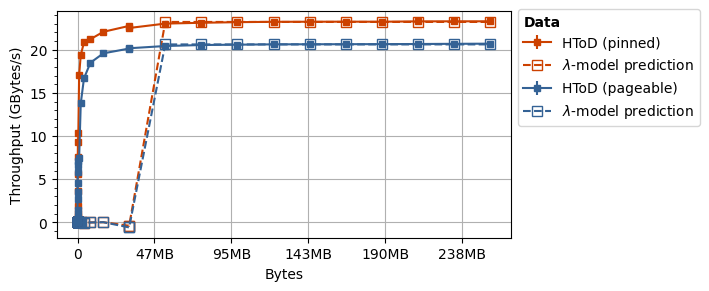

In [184]:
save = False; figname = f"{gpu_output_folder}/gpu_memtransfers_mb_calib_throughput.pdf"  # fmt: skip
# save = False; figname = f"{gpu_output_folder}/gpu_memtransfers_mb_calib_lambda.pdf"  # fmt: skip
unit = "s"
data_unit = "gb"
rep = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)
dir = "HToD"

fig = plt.figure(figsize=(10, 3))

for pi, pinned in enumerate([True, False]):
    ax = plt.subplot(121)
    arg = mcpybm_mean["pinned"] == pinned
    # plt.plot(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["nbytes"]/mcpybm_mean.loc[arg]["real_time"] * norm, "o-")
    nbytes = mcpybm_mean.loc[arg]["nbytes"]
    avg = mcpybm_mean.loc[arg]["real_time"]
    std = mcpybm_std.loc[arg]["real_time"]
    p = plt.errorbar(
        nbytes,
        # (mcpybm_mean.loc[arg]["real_time"] * norm)/
        #    (mcpybm_mean.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)),
        (nbytes * data_norm) / (avg * norm),
        yerr=(mcpybm_std.loc[arg]["nbytes"] * data_norm) / (std * norm),
        label=f"{dir} ({('pinned' if pinned else 'pageable')})",
        # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
        color=colors[pinned],
        **bm_style,
    )

    plt.xlabel("Bytes")
    # plt.xlim([gpu_bw_threshold, 200e9])
    # plt.ylim([0, 5000])
    # plt.xscale("log", base=2)
    # plt.yscale("symlog")
    # plt.yscale("log")
    # plt.ylabel(f"Average runtime\nper transfer ({unit})")
    plt.ylabel(f"Throughput ({data_unit.upper()[0]}Bytes/{unit})")
    plt.grid()
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
    )
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

    ## Prediction
    pred = (
        (nbytes * data_norm) / (T_memcpy_das6(nbytes, pinned) * unit_to_unit_factor("ns", unit))
    )
    ax.errorbar(
        nbytes, pred, label="$\lambda$-model prediction", color=p[0].get_color(), **pred_nocolor_style
    )

plt.tight_layout()
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="center left",
    bbox_to_anchor=(1, 0.75),
    ncols=1,
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

Error function

In [185]:
def ibw_small(bytes, a, b, c, d):
    return a * scipy.special.erf((bytes - b)*c) + d

def get_erf_label(popt, r=1):
    a,b,c,d = np.round(popt, r)
    l = ""
    if a != 0:
        l+= str(a) + " * "
    l+= "Erf((x"
    if b != 0:
        if b > 0: 
            l += " + "
        l += str(b)
    l += ")"
    if c != 0:
        l += " * " + str(c)
    l += ")"
    if d != 0:
        if d > 0: 
            l += " + "
        l += str(d)
    
    return l

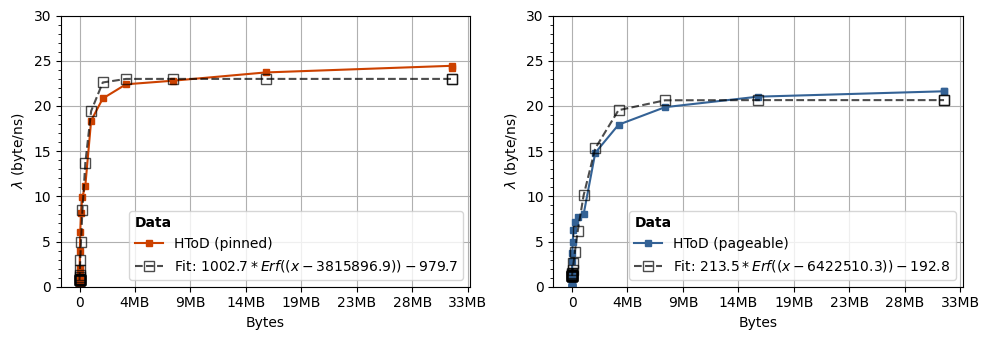

In [186]:
save = True; figname = f"{gpu_output_folder}/gpu_memtransfers_calib_small_throughput_erf.pdf"  # fmt: skip

unit = "ns"
data_unit = "b"
rep = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
dir = "HToD"
deg = 8

fig = plt.figure(figsize=(10, 3.5))

ax = plt.subplot(121)
pinned = True
arg = mcpybm_mean["pinned"] == pinned

ylambda = mcpybm_mean.loc[arg]["real_time"] * norm - gpu_alpha_pinned
ylambda_std = mcpybm_std.loc[arg]["real_time"] * norm
xbytes = mcpybm_mean.loc[arg]["nbytes"]
# print(mcpybm_mean.loc[arg]["real_time"] * norm  - gpu_alpha_pinned)
mask = (xbytes > 1) & (xbytes < gpu_bw_threshold)
p = plt.errorbar(
    xbytes[mask],
    xbytes[mask]/ylambda[mask],
    # yerr=ylambda_std[mask] / xbytes[mask],
    label=f"{dir} ({('pinned' if pinned else 'pageable')})",
    color=colors[1],
    # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
    **bm_style,
)

ibw_smallpinned_popt = []
# The initial guess of the parameters to be found by curve_fit.
# Warning: in general, an array of ones might not be a good enough
# guess for `curve_fit`, but in this example, it works.
# p0 = np.ones(n) * 1
ibw_smallpinned_popt, pcov = scipy.optimize.curve_fit(
    ibw_small,
    xbytes[mask],
    xbytes[mask]/ylambda[mask],
    p0=[16,1,1,0],
    method="trf",
    # bounds=(0,np.inf),
    maxfev=1e9,
)
plt.errorbar(
    xbytes[mask],
    ibw_small(xbytes[mask], *ibw_smallpinned_popt),
    # c=p[0].get_color(),
    c="k",
    alpha=0.1 * i + 0.4,
    **pred_nocolor_style,
    label=f"Fit: ${get_erf_label(ibw_smallpinned_popt)}$",
)

# ibw_smallpinned_popt, pcov = scipy.optimize.curve_fit(
#     ibw_small,
#     xbytes[mask],
#     ylambda[mask] * unit_to_unit_factor(unit, "ns"),
#     # p0=[6784,24,0],
#     # method='trf',
#     # bounds=(0,np.inf),
#     # p0=[6.315361645565791e-11, 0],
#     # maxfev=100000
# )
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="lower right",
    # bbox_to_anchor=(1, 0.75),
    # ncols=1,
)

plt.xlabel("Bytes")
# plt.xscale("log", base=2)
# plt.yscale("symlog")
plt.ylabel(f"$\lambda$ ({data_unit}yte/{unit})")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))
plt.ylim([0, 30])

##############
ax = plt.subplot(122)

pinned = False
arg = mcpybm_mean["pinned"] == pinned
xbytes = mcpybm_mean.loc[arg]["nbytes"]
mask = (xbytes > 1) & (xbytes < gpu_bw_threshold)
ylambda = mcpybm_mean.loc[arg]["real_time"] * norm - gpu_alpha_paged
ylambda_std = mcpybm_std.loc[arg]["real_time"] * norm

p = plt.errorbar(
    xbytes[mask],
    xbytes[mask]/ylambda[mask],
    # yerr=ylambda_std[mask] / xbytes[mask],
    label=f"{dir} ({('pinned' if pinned else 'pageable')})",
    color=colors[0],
    # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
    **bm_style,
)

p0 = np.ones(n) * 0.1
ibw_smallpaged_popt, pcov = scipy.optimize.curve_fit(
    ibw_small,
    xbytes[mask],
    xbytes[mask]/ylambda[mask],
    # p0=[0,16e3,15,1],
    method="trf",
    maxfev=1e6,
    # bounds=(0,np.inf),
)
# ibw_smallpaged_popt=[19.2, 16e3, 0.11, 1.3]
plt.errorbar(
    xbytes[mask],
    ibw_small(xbytes[mask], *ibw_smallpaged_popt),
    # c=p[0].get_color(),
    c="k",
    alpha=0.1 * i + 0.4,
    **pred_nocolor_style,
    label=f"Fit: ${get_erf_label(ibw_smallpaged_popt)}$",
)

# ibw_smallpaged_popt, pcov = scipy.optimize.curve_fit(
#     ibw_small,
#     xbytes[mask],
#     ylambda[mask] * unit_to_unit_factor(unit, "ns"),
#     # p0=[6e-2, 6e3, 0, 0, 0, 0],
#     # method='trf',
#     # bounds=(0,np.inf),
#     maxfev=100000,
# )
# plt.errorbar(
#     xbytes[mask],
#     ibw_small(xbytes[mask], *ibw_smallpaged_popt),
#     c=p[0].get_color(),
#     **pred_nocolor_style,
#     label=f"Fit ${get_poly_label(ibw_smallpaged_popt)}$",
# )

# plt.plot(xbytes[mask], 6e-2*xbytes[mask] + 6e3, "--")
plt.xlabel("Bytes")
# plt.xlim([0, 10e6])
plt.ylim([0, 30])
# plt.xscale("log", base=2)
# plt.yscale("symlog")
# plt.yscale("log")
# plt.ylabel(f"$\lambda$ ({unit}/byte)")
plt.ylabel(f"$\lambda$ ({data_unit}yte/{unit})")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

plt.tight_layout()
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="lower right",
    # bbox_to_anchor=(1, 0.75),
    # ncols=1,
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [187]:
def T_memcpy_das6(bytes, pinned):
    alpha = gpu_alpha_pinned if pinned else gpu_alpha_paged
    maxibw = gpu_maxibw_htod_pinned if pinned else gpu_maxibw_htod_paged
    popt = ibw_smallpinned_popt if pinned else ibw_smallpaged_popt

    try:
        T = np.zeros(len(bytes)).astype(np.float64)
        T[bytes < gpu_bw_threshold] = (
            (1/ibw_small(bytes[bytes < gpu_bw_threshold], *popt))
            * bytes[bytes < gpu_bw_threshold]
        )
        T[bytes >= gpu_bw_threshold] = maxibw * bytes[bytes >= gpu_bw_threshold]
    except:
        if bytes < gpu_bw_threshold:
            T = (1/ibw_small(bytes, *popt)) * bytes
        else:
            T = maxibw * bytes
    return T

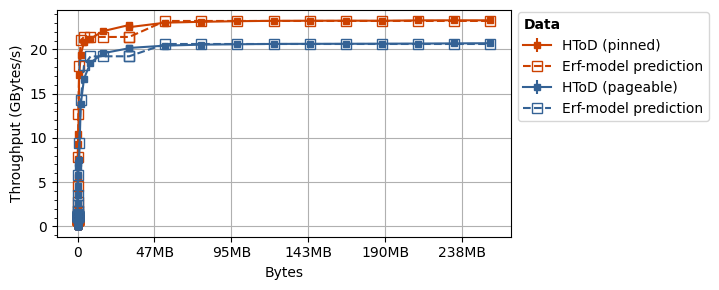

In [188]:
save = True; figname = f"{gpu_output_folder}/gpu_memtransfers_mb_calib_throughput_erf.pdf"  # fmt: skip
# save = False; figname = f"{gpu_output_folder}/gpu_memtransfers_mb_calib_lambda.pdf"  # fmt: skip
unit = "s"
data_unit = "gb"
rep = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)
dir = "HToD"

fig = plt.figure(figsize=(10, 3))

for pi, pinned in enumerate([True, False]):
    ax = plt.subplot(121)
    arg = mcpybm_mean["pinned"] == pinned
    # plt.plot(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["nbytes"]/mcpybm_mean.loc[arg]["real_time"] * norm, "o-")
    nbytes = mcpybm_mean.loc[arg]["nbytes"]
    avg = mcpybm_mean.loc[arg]["real_time"]
    std = mcpybm_std.loc[arg]["real_time"]
    p = plt.errorbar(
        nbytes,
        # (mcpybm_mean.loc[arg]["real_time"] * norm)/
        #    (mcpybm_mean.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)),
        (nbytes * data_norm) / (avg * norm),
        yerr=(mcpybm_std.loc[arg]["nbytes"] * data_norm) / (std * norm),
        label=f"{dir} ({('pinned' if pinned else 'pageable')})",
        # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
        color=colors[pinned],
        **bm_style,
    )

    plt.xlabel("Bytes")
    # plt.xlim([gpu_bw_threshold, 200e9])
    # plt.ylim([0, 5000])
    # plt.xscale("log", base=2)
    # plt.yscale("symlog")
    # plt.yscale("log")
    # plt.ylabel(f"Average runtime\nper transfer ({unit})")
    plt.ylabel(f"Throughput ({data_unit.upper()[0]}Bytes/{unit})")
    plt.grid()
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
    )
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:g}".format(y)))

    ## Prediction
    pred = (
        (nbytes * data_norm) / (T_memcpy_das6(nbytes, pinned) * unit_to_unit_factor("ns", unit))
    )
    ax.errorbar(
        nbytes, pred, label="Erf-model prediction", color=p[0].get_color(), **pred_nocolor_style
    )

plt.tight_layout()
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="center left",
    bbox_to_anchor=(1, 0.75),
    ncols=1,
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

## Validation

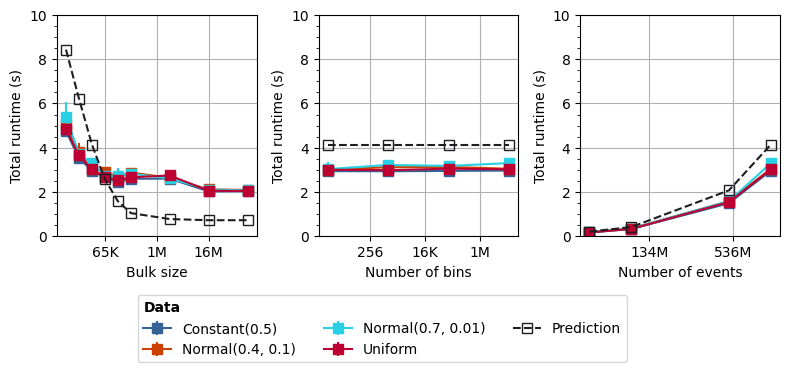

In [191]:
save = True; figname = f"{gpu_output_folder}/gpu_memcpy_validation_verbose.pdf"  # fmt: skip

selected_env = "CUDA"
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = False
unit = "s"
norm = unit_to_unit_factor("ns", unit)
hmax = 10

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(132)

dir = "HtoD"
api = "cudaMemcpy"
for di, distr in enumerate(selected_distr):
    marg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        vd_unique_nbins,
        selected_bulksize,
        selected_edges,
        dir,
    )
    aarg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        vd_unique_nbins,
        selected_bulksize,
        selected_edges,
        api,
    )
    avg = gpu_gpmemops.mean().loc[marg] + gpu_gpapi.mean().loc[aarg]
    std = gpu_gpmemops.std().loc[marg] + gpu_gpapi.std().loc[aarg]

    p = ax.errorbar(
        vd_unique_nbins,
        avg["Total Time (ns)"] * norm,
        yerr=std["Total Time (ns)"] * norm,
        label=f"{map_distr_name(distr)}".title(),
        **vd_style,
    )

## Prediction
pred = (
    2
    * T_memcpy_das6(selected_bulksize * 8, False)
    * (selected_nvals / selected_bulksize)
    * norm
)
ax.errorbar(
    vd_unique_nbins,
    np.repeat(pred, len(vd_unique_nbins)),
    label="Prediction",
    **pred_style,
)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

#####################
ax = plt.subplot(133)
for di, distr in enumerate(selected_distr):
    marg = (
        selected_env,
        selected_gpu,
        distr,
        vd_unique_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
        dir,
    )
    aarg = (
        selected_env,
        selected_gpu,
        distr,
        vd_unique_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
        api,
    )
    avg = gpu_gpmemops.mean().loc[marg] + gpu_gpapi.mean().loc[aarg]
    std = gpu_gpmemops.std().loc[marg] + gpu_gpapi.std().loc[aarg]

    p = ax.errorbar(
        vd_unique_nvals,
        avg["Total Time (ns)"] * norm,
        yerr=std["Total Time (ns)"] * norm,
        label=f"{map_distr_name(distr)}".title(),
        **vd_style,
    )

## Prediction
pred = (
    2
    * T_memcpy_das6(selected_bulksize * 8, False)
    * (vd_unique_nvals / selected_bulksize)
    * norm
)
ax.errorbar(vd_unique_nvals, pred, label="Prediction", **pred_style)

plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

#####################
ax = plt.subplot(131)
for di, distr in enumerate(selected_distr):
    marg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        selected_nbins,
        vd_unique_bulksize,
        selected_edges,
        dir,
    )
    aarg = (
        selected_env,
        selected_gpu,
        distr,
        selected_nvals,
        selected_nbins,
        vd_unique_bulksize,
        selected_edges,
        api,
    )
    avg = gpu_gpmemops.mean().loc[marg] + gpu_gpapi.mean().loc[aarg]
    std = gpu_gpmemops.std().loc[marg] + gpu_gpapi.std().loc[aarg]

    p = ax.errorbar(
        vd_unique_bulksize,
        avg["Total Time (ns)"] * norm,
        yerr=std["Total Time (ns)"] * norm,
        label=f"{map_distr_name(distr)}".title(),
        **vd_style,
    )

## Prediction
pred = (
    2
    * T_memcpy_das6(vd_unique_bulksize * 8, False)
    * (selected_nvals / vd_unique_bulksize)
    * norm
)
ax.errorbar(vd_unique_bulksize, pred, label="Prediction", **pred_style)

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

##############
fig.tight_layout()
ax = plt.subplot(133)
ax.legend(
    title="Data",
    loc="lower left",
    bbox_to_anchor=(-2.25, -0.6),
    ncols=3,
    alignment="left",
    title_fontproperties={"weight": "bold"},
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
save = global_save; figname = f"{gpu_output_folder}/gpu_memcpy_validation.pdf"  # fmt: skip

selected_env = "CUDA"
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = False
unit = "s"
norm = unit_to_unit_factor("ns", unit)
hmax = 10

fig = plt.figure(figsize=(5, 3))
# ax = plt.subplot(131)

#####################
ax = plt.subplot(111)
marg = (
    selected_env,
    selected_gpu,
    distr,
    selected_nvals,
    selected_nbins,
    vd_unique_bulksize,
    selected_edges,
    dir,
)
aarg = (
    selected_env,
    selected_gpu,
    distr,
    selected_nvals,
    selected_nbins,
    vd_unique_bulksize,
    selected_edges,
    api,
)
avg = gpu_gpmemops.mean().loc[marg] + gpu_gpapi.mean().loc[aarg]
std = gpu_gpmemops.std().loc[marg] + gpu_gpapi.std().loc[aarg]

p = ax.errorbar(
    vd_unique_bulksize,
    avg["Total Time (ns)"] * norm,
    yerr=std["Total Time (ns)"] * norm,
    label=f"Benchmark",
    **vd_style,
)

## Prediction
pred = (
    2
    * T_memcpy_das6(vd_unique_bulksize * 8, False)
    * (selected_nvals / vd_unique_bulksize)
    * norm
)
ax.errorbar(vd_unique_bulksize, pred, label="Prediction", **pred_style)

plt.xlabel("Bulk size\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=8)}"
    )
)
plt.ylim([0, hmax])
plt.ylabel("Average total\nHToD copy runtime (s)")


##############
fig.tight_layout()
# plt.legend(title="Data", loc='lower left',  bbox_to_anchor=(-1.75, -.6), ncols=3,
#            alignment="left", title_fontproperties={'weight':'bold'})
plt.legend(
    title="Data",
    alignment="left",
    title_fontproperties={"weight": "bold"},
    loc="center left",
    bbox_to_anchor=(1, 0.7),
    ncols=1,
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

# Total Validation

## Total vs. inner

In [ ]:
save = global_save; figname = f"{gpu_output_folder}/gpu_total_vs_inner.pdf"  # fmt: skip

selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
selected_edges = True
unit = "s"
norm = unit_to_unit_factor("ns", "s")
include_api = True

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi * 3 + 1)

    for distr in vd_unique_distributions:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            selected_nbins,
            vd_unique_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_bulksize,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = (
                gpu_gp_kernels.mean()
                .loc[arg]
                .reset_index()
                .groupby(["bulksize"])
                .sum()["Total Time (ns)"]
            )
            tmemop = (
                gpu_gpmemops.mean()
                .loc[arg]
                .reset_index()
                .groupby(["bulksize"])
                .sum()["Total Time (ns)"]
            )
            tapi = (
                gpu_gpapi.mean()
                .loc[arg]
                .reset_index()
                .groupby(["bulksize"])
                .sum()["Total Time (ns)"]
                * include_api
            )
            tkernels_std = (
                gpu_gp_kernels.std()
                .loc[arg]
                .reset_index()
                .groupby(["bulksize"])
                .sum()["Total Time (ns)"]
            )
            tmemop_std = (
                gpu_gpmemops.std()
                .loc[arg]
                .reset_index()
                .groupby(["bulksize"])
                .sum()["Total Time (ns)"]
            )
            tapi_std = (
                gpu_gpapi.std()
                .loc[arg]
                .reset_index()
                .groupby(["bulksize"])
                .sum()["Total Time (ns)"]
            )
            p = plt.errorbar(
                vd_unique_bulksize,
                (tkernels + tmemop + tapi) * norm,
                yerr=(tkernels_std + tmemop_std + tapi_std) * norm,
                **sum_style,
                color=p[0].get_color(),
            )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    if edi == 1:
        plt.xlabel("Bulk size")

    plt.ylim([0, 20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 2)

    for distr in vd_unique_distributions:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            vd_unique_nvals,
            selected_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = (
                gpu_gp_kernels.mean()
                .loc[arg]
                .reset_index()
                .groupby(["nvals"])
                .sum()["Total Time (ns)"]
            )
            tmemop = (
                gpu_gpmemops.mean()
                .loc[arg]
                .reset_index()
                .groupby(["nvals"])
                .sum()["Total Time (ns)"]
            )
            tapi = (
                gpu_gpapi.mean()
                .loc[arg]
                .reset_index()
                .groupby(["nvals"])
                .sum()["Total Time (ns)"]
                * include_api
            )
            tkernels_std = (
                gpu_gp_kernels.std()
                .loc[arg]
                .reset_index()
                .groupby(["nvals"])
                .sum()["Total Time (ns)"]
            )
            tmemop_std = (
                gpu_gpmemops.std()
                .loc[arg]
                .reset_index()
                .groupby(["nvals"])
                .sum()["Total Time (ns)"]
            )
            tapi_std = (
                gpu_gpapi.std()
                .loc[arg]
                .reset_index()
                .groupby(["nvals"])
                .sum()["Total Time (ns)"]
            )
            p = plt.errorbar(
                vd_unique_nvals,
                (tkernels + tmemop + tapi) * norm,
                yerr=(tkernels_std + tmemop_std + tapi_std) * norm,
                **sum_style,
                color=p[0].get_color(),
            )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    if edi == 1:
        plt.xlabel("Number of events")

    plt.ylim([0, 20])
    plt.title(f"{'Variable' if edg else 'Fixed'} bins")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 3)

    # Legend Labels
    ax.plot(0, 0, label="Measured total runtime", c="k", **vd_style)
    plt.plot(0, 0, label="Sum of measured components", c="k", **sum_style)

    for distr in vd_unique_distributions:
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            vd_unique_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nbins,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = (
                gpu_gp_kernels.mean()
                .loc[arg]
                .reset_index()
                .groupby(["nbins"])
                .sum()["Total Time (ns)"]
            )
            tmemop = (
                gpu_gpmemops.mean()
                .loc[arg]
                .reset_index()
                .groupby(["nbins"])
                .sum()["Total Time (ns)"]
            )
            tapi = (
                gpu_gpapi.mean()
                .loc[arg]
                .reset_index()
                .groupby(["nbins"])
                .sum()["Total Time (ns)"]
                * include_api
            )
            tkernels_std = (
                gpu_gp_kernels.std()
                .loc[arg]
                .reset_index()
                .groupby(["nbins"])
                .sum()["Total Time (ns)"]
            )
            tmemop_std = (
                gpu_gpmemops.std()
                .loc[arg]
                .reset_index()
                .groupby(["nbins"])
                .sum()["Total Time (ns)"]
            )
            tapi_std = (
                gpu_gpapi.std()
                .loc[arg]
                .reset_index()
                .groupby(["nbins"])
                .sum()["Total Time (ns)"]
            )
            p = plt.errorbar(
                vd_unique_nbins,
                (tkernels + tmemop + tapi) * norm,
                yerr=(tkernels_std + tmemop_std + tapi_std) * norm,
                **sum_style,
                color=p[0].get_color(),
            )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0, 20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.15, -0.15),
    ncols=3,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Average runtime (s)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

## Runtime

In [ ]:
save = global_save; figname = f"{gpu_output_folder}/gpu_validation.pdf"  # fmt: skip

selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 1e3
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
# selected_distr = ['normal-0.7-0.01', 'normal-0.4-0.1', ]
edg = True
unit = "s"
norm = unit_to_unit_factor("ns", "s")

hmax_exp = 20
hdifd_imp = 0
fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi * 3 + 1)

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            selected_nbins,
            vd_unique_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_bulksize,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
        )

        # Prediction
        blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(vd_unique_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, vd_unique_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)
        T_memcpy = 2 * T_memcpy_das6(vd_unique_bulksize * 8, False)
        p = plt.errorbar(
            vd_unique_bulksize,
            (selected_nvals / vd_unique_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Bulk size")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 3)

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            vd_unique_nvals,
            selected_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        p = plt.errorbar(
            vd_unique_nvals,
            (vd_unique_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of events")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 2)
    plt.title(f"{'Variable' if edg else 'Fixed'} bins")

    # Legend Labels
    plot_validation_labels()

    for distr in selected_distr:
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            vd_unique_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nbins,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            vd_unique_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, vd_unique_nbins
        )
        T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        p = plt.errorbar(
            vd_unique_nbins,
            (selected_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of bins")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.15, -0.15),
    ncols=3,
    # bbox_to_anchor=(1, 0.53),
    # ncols=1,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Average runtime (s)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

In [ ]:
gpu_factorvar = 2; gpu_factorfix = 2; save = global_save; figname = f"{gpu_output_folder}/gpu_validation_mul-t{gpu_factorvar}-b{gpu_factorfix}.pdf"  # fmt: skip

selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
# selected_distr = ['normal-0.7-0.01']
edg = True
unit = "s"
norm = unit_to_unit_factor("ns", "s")

fig = plt.figure(figsize=(8, 3))

for edi, edg in enumerate([True]):
    ax = plt.subplot(1, 3, edi * 3 + 1)
    factor = gpu_factorvar if edg else gpu_factorfix

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            selected_nbins,
            vd_unique_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_bulksize,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
        )

        # Prediction
        blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(vd_unique_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, vd_unique_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)
        T_memcpy = 2 * T_memcpy_das6(vd_unique_bulksize * 8, False)
        pred = (
            (selected_nvals / vd_unique_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )
        p = plt.errorbar(
            vd_unique_bulksize,
            pred * factor,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    if edi == 1:
        plt.xlabel("Bulk size")

    plt.ylim([0, 20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(1, 3, edi * 3 + 2)

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            vd_unique_nvals,
            selected_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        pred = (
            (vd_unique_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )
        p = plt.errorbar(
            vd_unique_nvals,
            pred * factor,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    if edi == 1:
        plt.xlabel("Number of events")

    plt.ylim([0, 20])
    plt.title(f"{'Variable' if edg else 'Fixed'} bins")
    #######################################################
    ax = plt.subplot(1, 3, edi * 3 + 3)

    # Legend Labels
    plot_validation_labels()

    for distr in selected_distr:
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            vd_unique_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nbins,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            vd_unique_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, vd_unique_nbins
        )
        T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        pred = (
            (selected_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )
        p = plt.errorbar(
            vd_unique_nbins,
            pred * factor,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0, 20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
# hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
# lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    # bbox_to_anchor=(0.15, -0.15),
    # ncols=3,
    bbox_to_anchor=(1, 0.27),
    ncols=1,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Average runtime (s)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

In [ ]:
gpu_factorvar = 3; gpu_factorfix = 2; save = global_save; figname = f"{gpu_output_folder}/gpu_validation_offset-t{gpu_factorvar}-b{gpu_factorfix}.pdf"  # fmt: skip

selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
# selected_distr = ['normal-0.7-0.01']
edg = True
unit = "s"
norm = unit_to_unit_factor("ns", "s")

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi * 3 + 1)
    factor = gpu_factorvar if edg else gpu_factorfix

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            selected_nbins,
            vd_unique_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_bulksize,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
        )

        # Prediction
        blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(vd_unique_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, vd_unique_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)
        T_memcpy = 2 * T_memcpy_das6(vd_unique_bulksize * 8, False)
        pred = (
            (selected_nvals / vd_unique_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )
        p = plt.errorbar(
            vd_unique_bulksize,
            pred + factor,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Bulk size")

    plt.ylim([0, 20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 3)

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            vd_unique_nvals,
            selected_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        pred = (
            (vd_unique_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )
        p = plt.errorbar(
            vd_unique_nvals,
            pred + factor,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of events")

    plt.ylim([0, 20])
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 2)
    plt.title(f"{'Variable' if edg else 'Fixed'} bins")

    # Legend Labels
    plot_validation_labels()

    for distr in selected_distr:
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            vd_unique_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gpu_gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(
            vd_unique_nbins,
            ttotal_avg,
            yerr=ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            vd_unique_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, vd_unique_nbins
        )
        T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        pred = (
            (selected_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )
        p = plt.errorbar(
            vd_unique_nbins,
            pred + factor,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of bins")

    plt.ylim([0, 20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
# hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
# lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.15, -0.15),
    ncols=3,
    # bbox_to_anchor=(1, 0.27),
    # ncols=1,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Average runtime (s)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

In [ ]:
T_memcpy * unit_to_unit_factor("ns", "s")

## Speedups

In [ ]:
%%capture
%run ../cpu-sequential/validation.ipynb

In [ ]:
cpgpu_unique_bulksize = np.array(
    [v for v in vd_unique_bulksize if v in cpu_validation_df["bulksize"].unique()]
)
cpgpu_unique_bulksize

In [ ]:
save = global_save; figname = f"{gpu_output_folder}/validation_speedups.pdf"  # fmt: skip
selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
unit = "s"
norm = unit_to_unit_factor("ns", "s")

fig = plt.figure(figsize=(8, 5))

hmax_exp = 600
hdifd_imp = 400
factor = 1
for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi * 3 + 1)

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            selected_nbins,
            cpgpu_unique_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values

        p = plt.errorbar(
            cpgpu_unique_bulksize,
            cttotal_avg / ttotal_avg,
            # yerr=cttotal_std/ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction GPU
        blocks = (cpgpu_unique_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(cpgpu_unique_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem,
            cpgpu_unique_bulksize,
            distr,
            selected_nbins,
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, cpgpu_unique_bulksize)
        T_memcpy = 2 * T_memcpy_das6(cpgpu_unique_bulksize * 8, False)
        T_gpu = (
            (selected_nvals / cpgpu_unique_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )

        # Prediction CPU
        # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_cpu_fill(distr, selected_nbins)
        tfindbin_pred = T_cpu_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * selected_nvals

        # Speedup
        speedup = T_cpu / T_gpu / factor
        p = plt.errorbar(
            vd_unique_bulksize,
            speedup,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Bulk size")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 2)

    # Legend Labels
    ax.plot(0, 0, label="Measured speedup", c="k", **vd_style)
    plt.plot(0, 0, label="Prediction", **pred_style)

    for distr in selected_distr:
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            vd_unique_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        p = plt.errorbar(
            vd_unique_nbins,
            cttotal_avg / ttotal_avg,
            # yerr=cttotal_std/ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction GPU
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            vd_unique_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, vd_unique_nbins
        )
        T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        T_gpu = (
            (selected_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )

        # Prediction CPU
        subsize = get_subsize(distr, vd_unique_nbins)
        tfill_pred = T_cpu_fill(distr, vd_unique_nbins)
        tfindbin_pred = T_cpu_findbin(edg, vd_unique_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * selected_nvals

        # Speedup
        speedup = T_cpu / T_gpu / factor
        p = plt.errorbar(
            vd_unique_nbins,
            speedup,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of bins")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    plt.title(f"{'Variable' if edg else 'Fixed'} bins")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 3)
    plot_validation_labels()

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            vd_unique_nvals,
            selected_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        p = plt.errorbar(
            vd_unique_nvals,
            cttotal_avg / ttotal_avg,
            # yerr=cttotal_std/ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction GPU
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        T_gpu = (
            (vd_unique_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )

        # Prediction CPU
        # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_cpu_fill(distr, selected_nbins)
        tfindbin_pred = T_cpu_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * vd_unique_nvals

        # Speedup
        speedup = T_cpu / T_gpu / factor
        p = plt.errorbar(
            vd_unique_nvals,
            speedup,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of events")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    #######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    # bbox_to_anchor=(1, 0.47),
    # ncols=1,
    bbox_to_anchor=(0.15, -0.15),
    ncols=3,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Speedup)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

In [ ]:
save = global_save; figname = f"{gpu_output_folder}/validation_speedups.pdf"  # fmt: skip
selected_env = "CUDA"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
unit = "s"
norm = unit_to_unit_factor("ns", "s")

fig = plt.figure(figsize=(8, 5))

hmax_exp = 120
hdifd_imp = 95
factor = 1
for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi * 3 + 1)
    factorcpu = factorvar if edg else factorfix
    factorgpu = gpu_factorvar if edg else gpu_factorfix

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            selected_nbins,
            cpgpu_unique_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values

        p = plt.errorbar(
            cpgpu_unique_bulksize,
            cttotal_avg / ttotal_avg,
            # yerr=cttotal_std/ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction GPU
        blocks = (cpgpu_unique_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(cpgpu_unique_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem,
            cpgpu_unique_bulksize,
            distr,
            selected_nbins,
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, cpgpu_unique_bulksize)
        T_memcpy = 2 * T_memcpy_das6(cpgpu_unique_bulksize * 8, False)
        T_gpu = (
            (selected_nvals / cpgpu_unique_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )

        # Prediction CPU
        # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_cpu_fill(selected_nbins, subsize)
        tfindbin_pred = T_cpu_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * selected_nvals

        # Speedup
        speedup = (T_cpu / factorcpu) / (T_gpu * factorgpu)
        p = plt.errorbar(
            vd_unique_bulksize,
            speedup,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Bulk size")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 2)

    # Legend Labels
    ax.plot(0, 0, label="Measured speedup", c="k", **vd_style)
    plt.plot(0, 0, label="Prediction", **pred_style)

    for distr in selected_distr:
        arg = (
            selected_env,
            selected_gpu,
            distr,
            selected_nvals,
            vd_unique_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        p = plt.errorbar(
            vd_unique_nbins,
            cttotal_avg / ttotal_avg,
            # yerr=cttotal_std/ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction GPU
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            vd_unique_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, vd_unique_nbins
        )
        T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        T_gpu = (
            (selected_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )

        # Prediction CPU
        subsize = get_subsize(distr, vd_unique_nbins)
        tfill_pred = T_cpu_fill(vd_unique_nbins, subsize)
        tfindbin_pred = T_cpu_findbin(edg, vd_unique_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * selected_nvals

        # Speedup
        speedup = (T_cpu / factorcpu) / (T_gpu * factorgpu)
        p = plt.errorbar(
            vd_unique_nbins,
            speedup,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of bins")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    plt.title(f"{'Variable' if edg else 'Fixed'} bins")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 3)
    plot_validation_labels()

    for distr in selected_distr:
        # Total
        arg = (
            selected_env,
            selected_gpu,
            distr,
            vd_unique_nvals,
            selected_nbins,
            selected_bulksize,
            edg,
        )
        ttotal_avg = gpu_gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        p = plt.errorbar(
            vd_unique_nvals,
            cttotal_avg / ttotal_avg,
            # yerr=cttotal_std/ttotal_std,
            **vd_style,
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        # Prediction GPU
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (
            selected_blocksize * 2
        )
        T_usb = 4 * (
            T_gpu_usb(selected_bulksize, *Tusb_popt)  # main reduction
            + T_gpu_usb(blocks, *Tusb_popt)
        )  # final reduction
        T_abc = T_gpu_addbincontent(
            selected_nbins * 8 > gpu_maxsmem, selected_bulksize, distr, selected_nbins
        )
        T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize * 8, False)
        T_gpu = (
            (vd_unique_nvals / selected_bulksize)
            * (T_usb + T_abc + T_fb + T_memcpy)
            * norm
        )

        # Prediction CPU
        # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_cpu_fill(selected_nbins, subsize)
        tfindbin_pred = T_cpu_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_cpu_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * vd_unique_nvals

        # Speedup
        speedup = (T_cpu / factorcpu) / (T_gpu * factorgpu)
        p = plt.errorbar(
            vd_unique_nvals,
            speedup,
            **pred_nocolor_style,
            color=p[0].get_color(),
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of events")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.15, -0.15),
    ncols=3,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Speedup)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")